# 1 Pre-process

## 1.1 Import packages

In [2]:
import pandas as pd
import re
import random
random.seed(16)

In [3]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

In [4]:
from matplotlib import font_manager

!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

font_dirs = ["/content"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

import matplotlib.pyplot as plt
plt.rc('font', family='Taipei Sans TC Beta')

--2022-01-14 08:30:10--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 142.250.98.139, 142.250.98.138, 142.250.98.100, ...
Connecting to drive.google.com (drive.google.com)|142.250.98.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/a6vajgj5emr9frfbubh7bpg2qac7dtk9/1642149000000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2022-01-14 08:30:11--  https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/a6vajgj5emr9frfbubh7bpg2qac7dtk9/1642149000000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)... 172.217.203.132, 2607:f8b0:400c:c07::84
Connecting to doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)|172.2

In [5]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

## 1.2 Read data

In [6]:
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials

# setup
gc = gspread.authorize(GoogleCredentials.get_application_default())

# read data and put it in a dataframe
gsheets = gc.open_by_url('https://docs.google.com/spreadsheets/d/1RQh9PFL1jwgAImNJeXjkPR58GtlPsR64Fj7Gpe-eS14/edit?usp=sharing')
sheets = gsheets.worksheet('Cleaned').get_all_values()
data = pd.DataFrame(sheets[1:], columns=sheets[0])
data = data[data.X != '']
data.dropna(how = 'all', inplace = True) 
data.head()

,,Number,pre,jia,post,sentence,cleaned,C*G,X,Y
0,0,86,。</p><p>另 賦稅署 去年 查獲 「,假,外資 真 逃稅 」 一 案 ， 成果,。</p><p>另 賦稅署 去年 查獲 「 假 外資 真 逃稅 」 一 案 ， 成果,另 賦稅署 去年 查獲 假 外資真逃稅 一 案 成果,假 外資 真 逃稅,外資,逃稅
1,1,177,展開 查緝 逃漏稅 行動 ， 繼 「,假,華僑 真 逃稅 」 案 後 ， 查緝,展開 查緝 逃漏稅 行動 ， 繼 「 假 華僑 真 逃稅 」 案 後 ， 查緝,展開 查緝 逃漏稅 行動 繼 假 華僑真逃稅 案 後 查緝,假 華僑 真 逃稅,華僑,逃稅
2,2,227,行動 已 一 系列 開展 ， 繼 「,假,華僑 真 逃稅 」 案 之後 ， 查緝,行動 已 一 系列 開展 ， 繼 「 假 華僑 真 逃稅 」 案 之後 ， 查緝,行動 已 一 系列 開展 繼 假 華僑真逃稅 案 之後 查緝,假 華僑 真 逃稅,華僑,逃稅
3,4,194,)<p>鑑於 近年 來 屢次 發生 「,假,進口 、 真 結匯 」 或 「 真 進口,)<p>鑑於 近年 來 屢次 發生 「 假 進口 、 真 結匯 」 或 「 真 進口,鑑於 近年 來 屢次 發生 假 進口 真結匯 或 真 進口,假 進口 、 真 結匯,進口,結匯
4,5,194,起 智慧型 犯罪 集團 ， 以 「,假,進口 、 真 結匯 」 或 「 真 進口,起 智慧型 犯罪 集團 ， 以 「 假 進口 、 真 結匯 」 或 「 真 進口,起 智慧型 犯罪 集團 以 假 進口 真結匯 或 真 進口,假 進口 、 真 結匯,進口,結匯


In [7]:
print(len(data['X'].unique()), len(data['Y'].unique()))

330 279


# 2 Node2Vec

## 2.1 Collect weight matrix

In [8]:
df = pd.DataFrame(data, columns = ['X', 'Y'])
weights_df = df.groupby(["X", "Y"]).size().rename('weights')
df = df.join(weights_df, on=["X", "Y"])
# print(df)
X_Y_df = df[df.weights > 1].sort_values(by = ['weights', 'X'], ascending = False)
# print(sp_df)

X_Y_df = X_Y_df.drop_duplicates().reset_index()
X_Y_df = X_Y_df.drop('index', 1)

X_Y_df['X'].str.strip(' ')
X_Y_df['Y'].str.strip(' ')

print(X_Y_df.head(5))

    X   Y  weights
0  出口  退稅       35
1  破產  逃債       32
2  消費  刷卡       27
3  車禍  搶劫       14
4  消費  詐財       11


## 2.2 Make plot

In [9]:
import networkx as nx
G = nx.DiGraph()
G.add_nodes_from(X_Y_df.X)
G.add_nodes_from(X_Y_df.Y)

for idx, row in X_Y_df.iterrows():
    G.add_edges_from([(row['X'], row['Y'], {'distance':row['weights']})])

In [10]:
color_map = []
for i in G:
    if (i in set(X_Y_df['X'])) and (i in set(X_Y_df['Y'])):
        color_map.append('#BBFF99')
    elif i in set(X_Y_df['X']):
        color_map.append('#FF9999')        
    elif i in set(X_Y_df['Y']):
        color_map.append('#ADD8E6')
    else:
        print("Error")

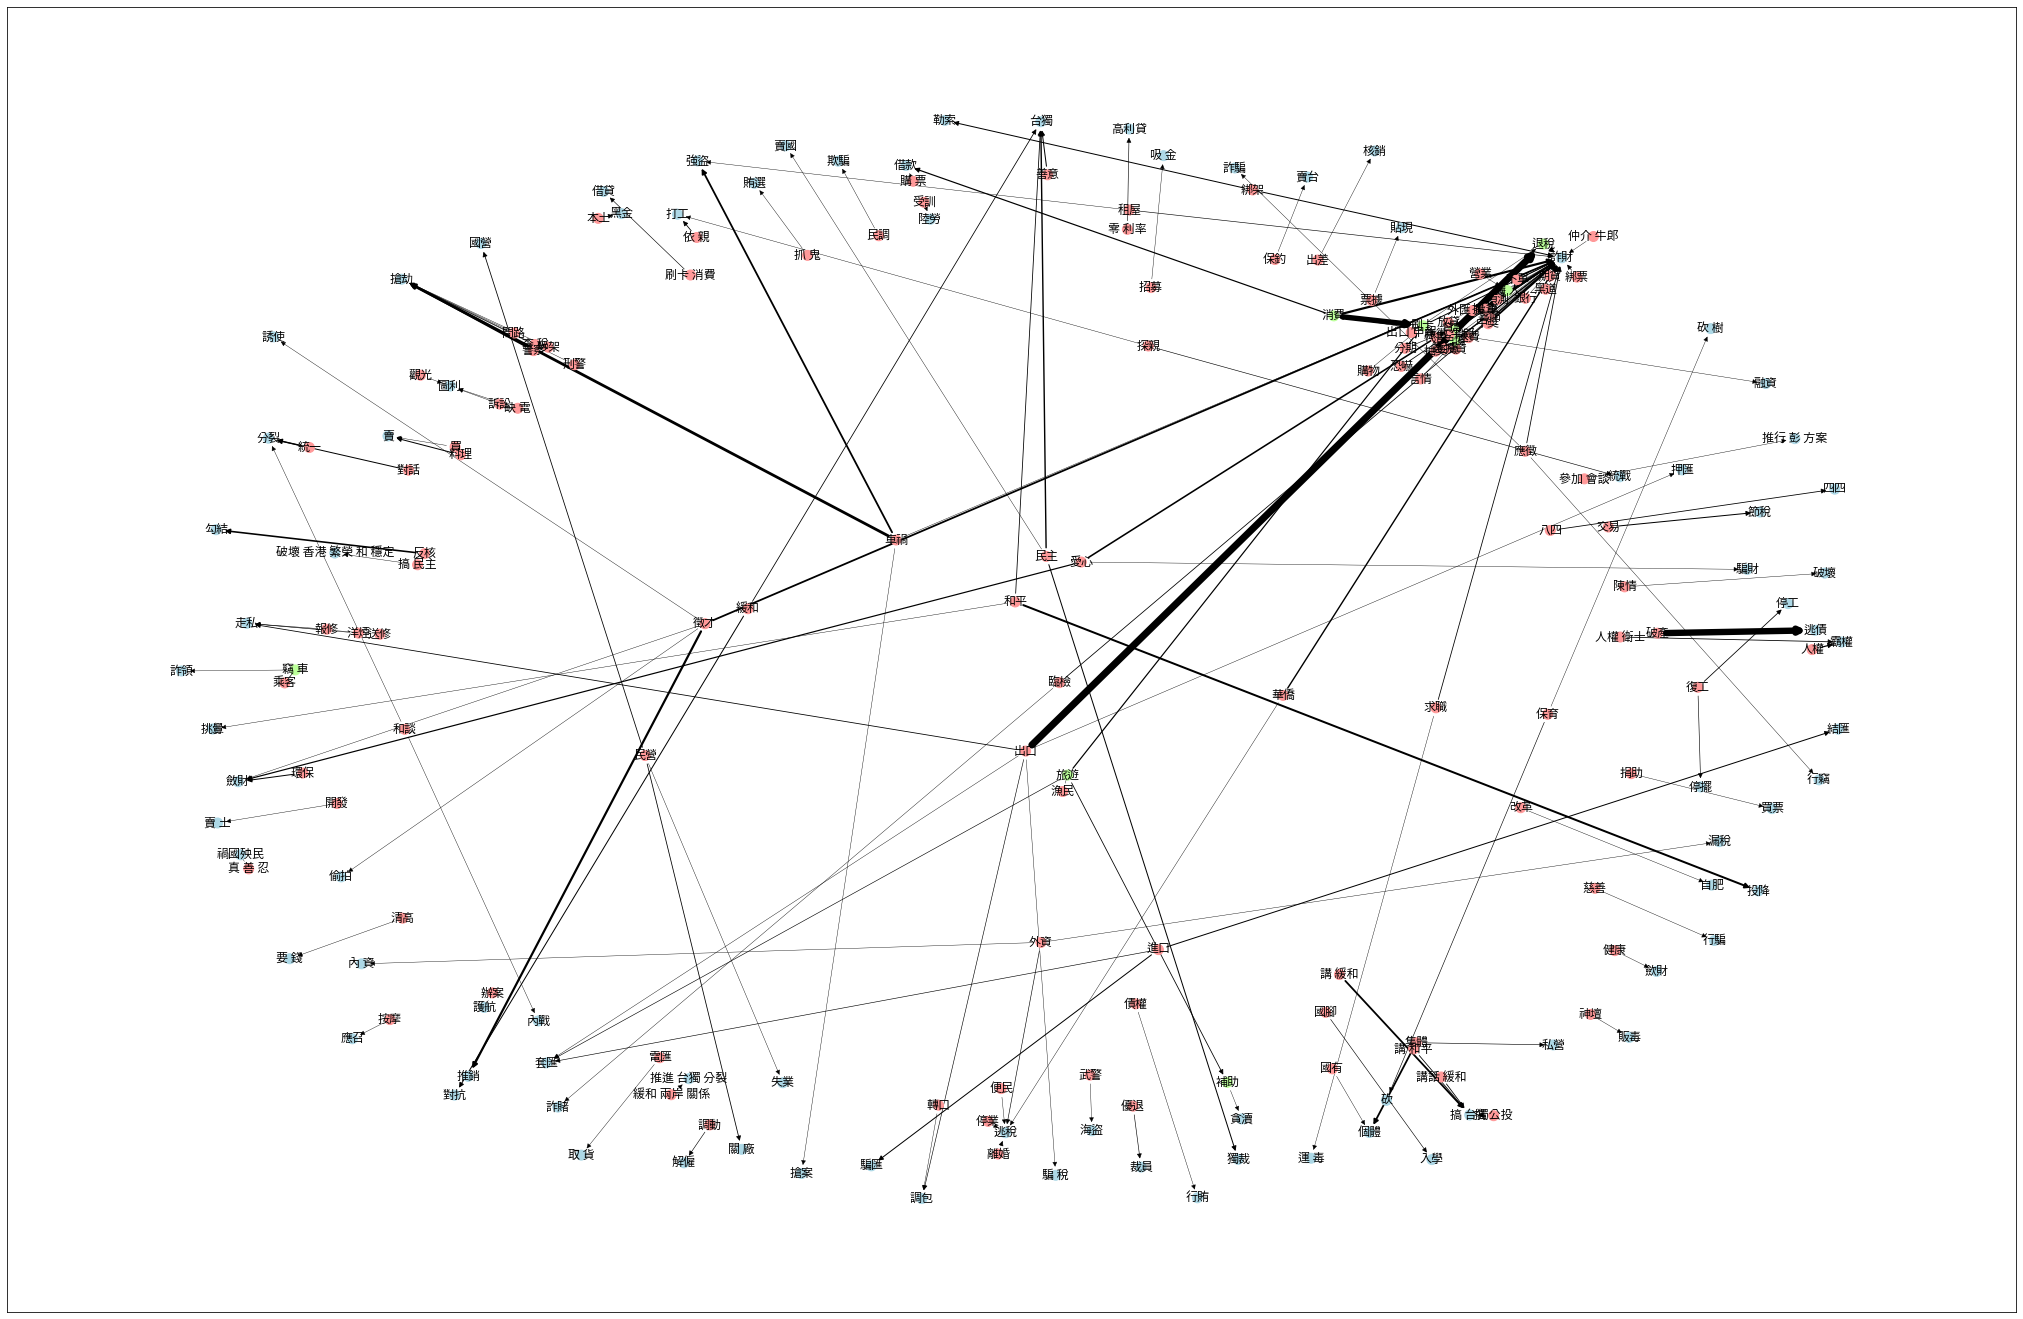

In [11]:
def plot_graph(G):
    weight_ls = []
    for j in dict(G.edges).values():
        for k in j.values():
            weight_ls.append(float(k))

    # weights = [i['weights']/5 for i in dict(G.edges).values()]
    weights = [i/5 for i in weight_ls]
    fig, ax = plt.subplots(figsize = (36,24))
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, ax = ax, node_color = color_map, node_size = 100)
    nx.draw_networkx_edges(G, pos, width = weights, ax = ax)
    _ = nx.draw_networkx_labels(G, pos, ax = ax, font_family = 'Taipei Sans TC Beta', font_size = 12)

random.seed(16)
plot_graph(G)

# 3 Pretrained FastText Model

## 3.1 Import fasttext

In [12]:
from google.colab import drive
drive.mount('/content/drive')

!wget -P /content/drive/MyDrive/NTU_Studies/2021_Fall

Mounted at /content/drive
wget: missing URL
Usage: wget [OPTION]... [URL]...

Try `wget --help' for more options.


In [13]:
!pip install fasttext
import fasttext
import fasttext.util

     |████████████████████████████████| 68 kB 3.2 MB/s 
  Using cached pybind11-2.9.0-py2.py3-none-any.whl (210 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3126867 sha256=19bb0a84d8450702064f12d0b9b0d0f90144f73887d410ebb0181194eedf63fd
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


In [14]:
ft = fasttext.load_model('/content/drive/MyDrive/NTU_Studies/2021_Fall/Computational Semantics/Term Paper/cc.zh.300.bin')

## 3.2 Construction matrix

In [15]:
vec_ls_ft = []

for i in data.iterrows():
    
    vec_X = ft.get_word_vector(i[1]['X'].replace(' ', ''))
    vec_Y = ft.get_word_vector(i[1]['Y'].replace(' ', ''))

    ls = [vec_X, vec_Y]
    vec_ls_ft.append(ls)

In [16]:
vec_df_ft = pd.DataFrame(vec_ls_ft)
vec_df_ft = vec_df_ft.rename(columns = {0:'X_vec', 1:'Y_vec'})

In [17]:
X_vec_df_ft = pd.DataFrame(vec_df_ft['X_vec'].to_list())
X = pd.DataFrame(data['X'])
X_vec_df_ft = X_vec_df_ft.join(X).set_index('X')

Y_vec_df_ft = pd.DataFrame(vec_df_ft['Y_vec'].to_list())
Y = pd.DataFrame(data['Y'])
Y_vec_df_ft = Y_vec_df_ft.join(Y).set_index('Y')

## 3.3 PCA to lower dimensions

In [18]:
# PCA to two dimensions

pca_matrix_X_ft = pca.fit(X_vec_df_ft).transform(X_vec_df_ft)
pca_df_X_ft = pd.DataFrame(pca_matrix_X_ft)
pca_df_X_ft = pca_df_X_ft.set_axis(["X", "Y"], axis=1)
pca_df_X_ft.index = X_vec_df_ft.index.to_list()
print(pca_df_X_ft.head(5))

pca_matrix_Y_ft = pca.fit(Y_vec_df_ft).transform(Y_vec_df_ft)
pca_df_Y_ft = pd.DataFrame(pca_matrix_Y_ft)
pca_df_Y_ft = pca_df_Y_ft.set_axis(["X", "Y"], axis=1)
pca_df_Y_ft.index = Y_vec_df_ft.index.to_list()
print(pca_df_Y_ft.head(5))

           X         Y
外資  0.016861  0.611377
華僑 -0.609820  0.296872
華僑 -0.609820  0.296872
進口 -0.441873  0.125637
進口 -0.441873  0.125637
           X         Y
逃稅  0.339344  0.936095
逃稅  0.339344  0.936095
逃稅  0.339344  0.936095
結匯 -0.678769  0.793195
結匯 -0.678769  0.793195


In [19]:
pca_df_X_ft.to_csv('X_ft.csv')
pca_df_Y_ft.to_csv('Y_ft.csv')

## 3.4 Plot

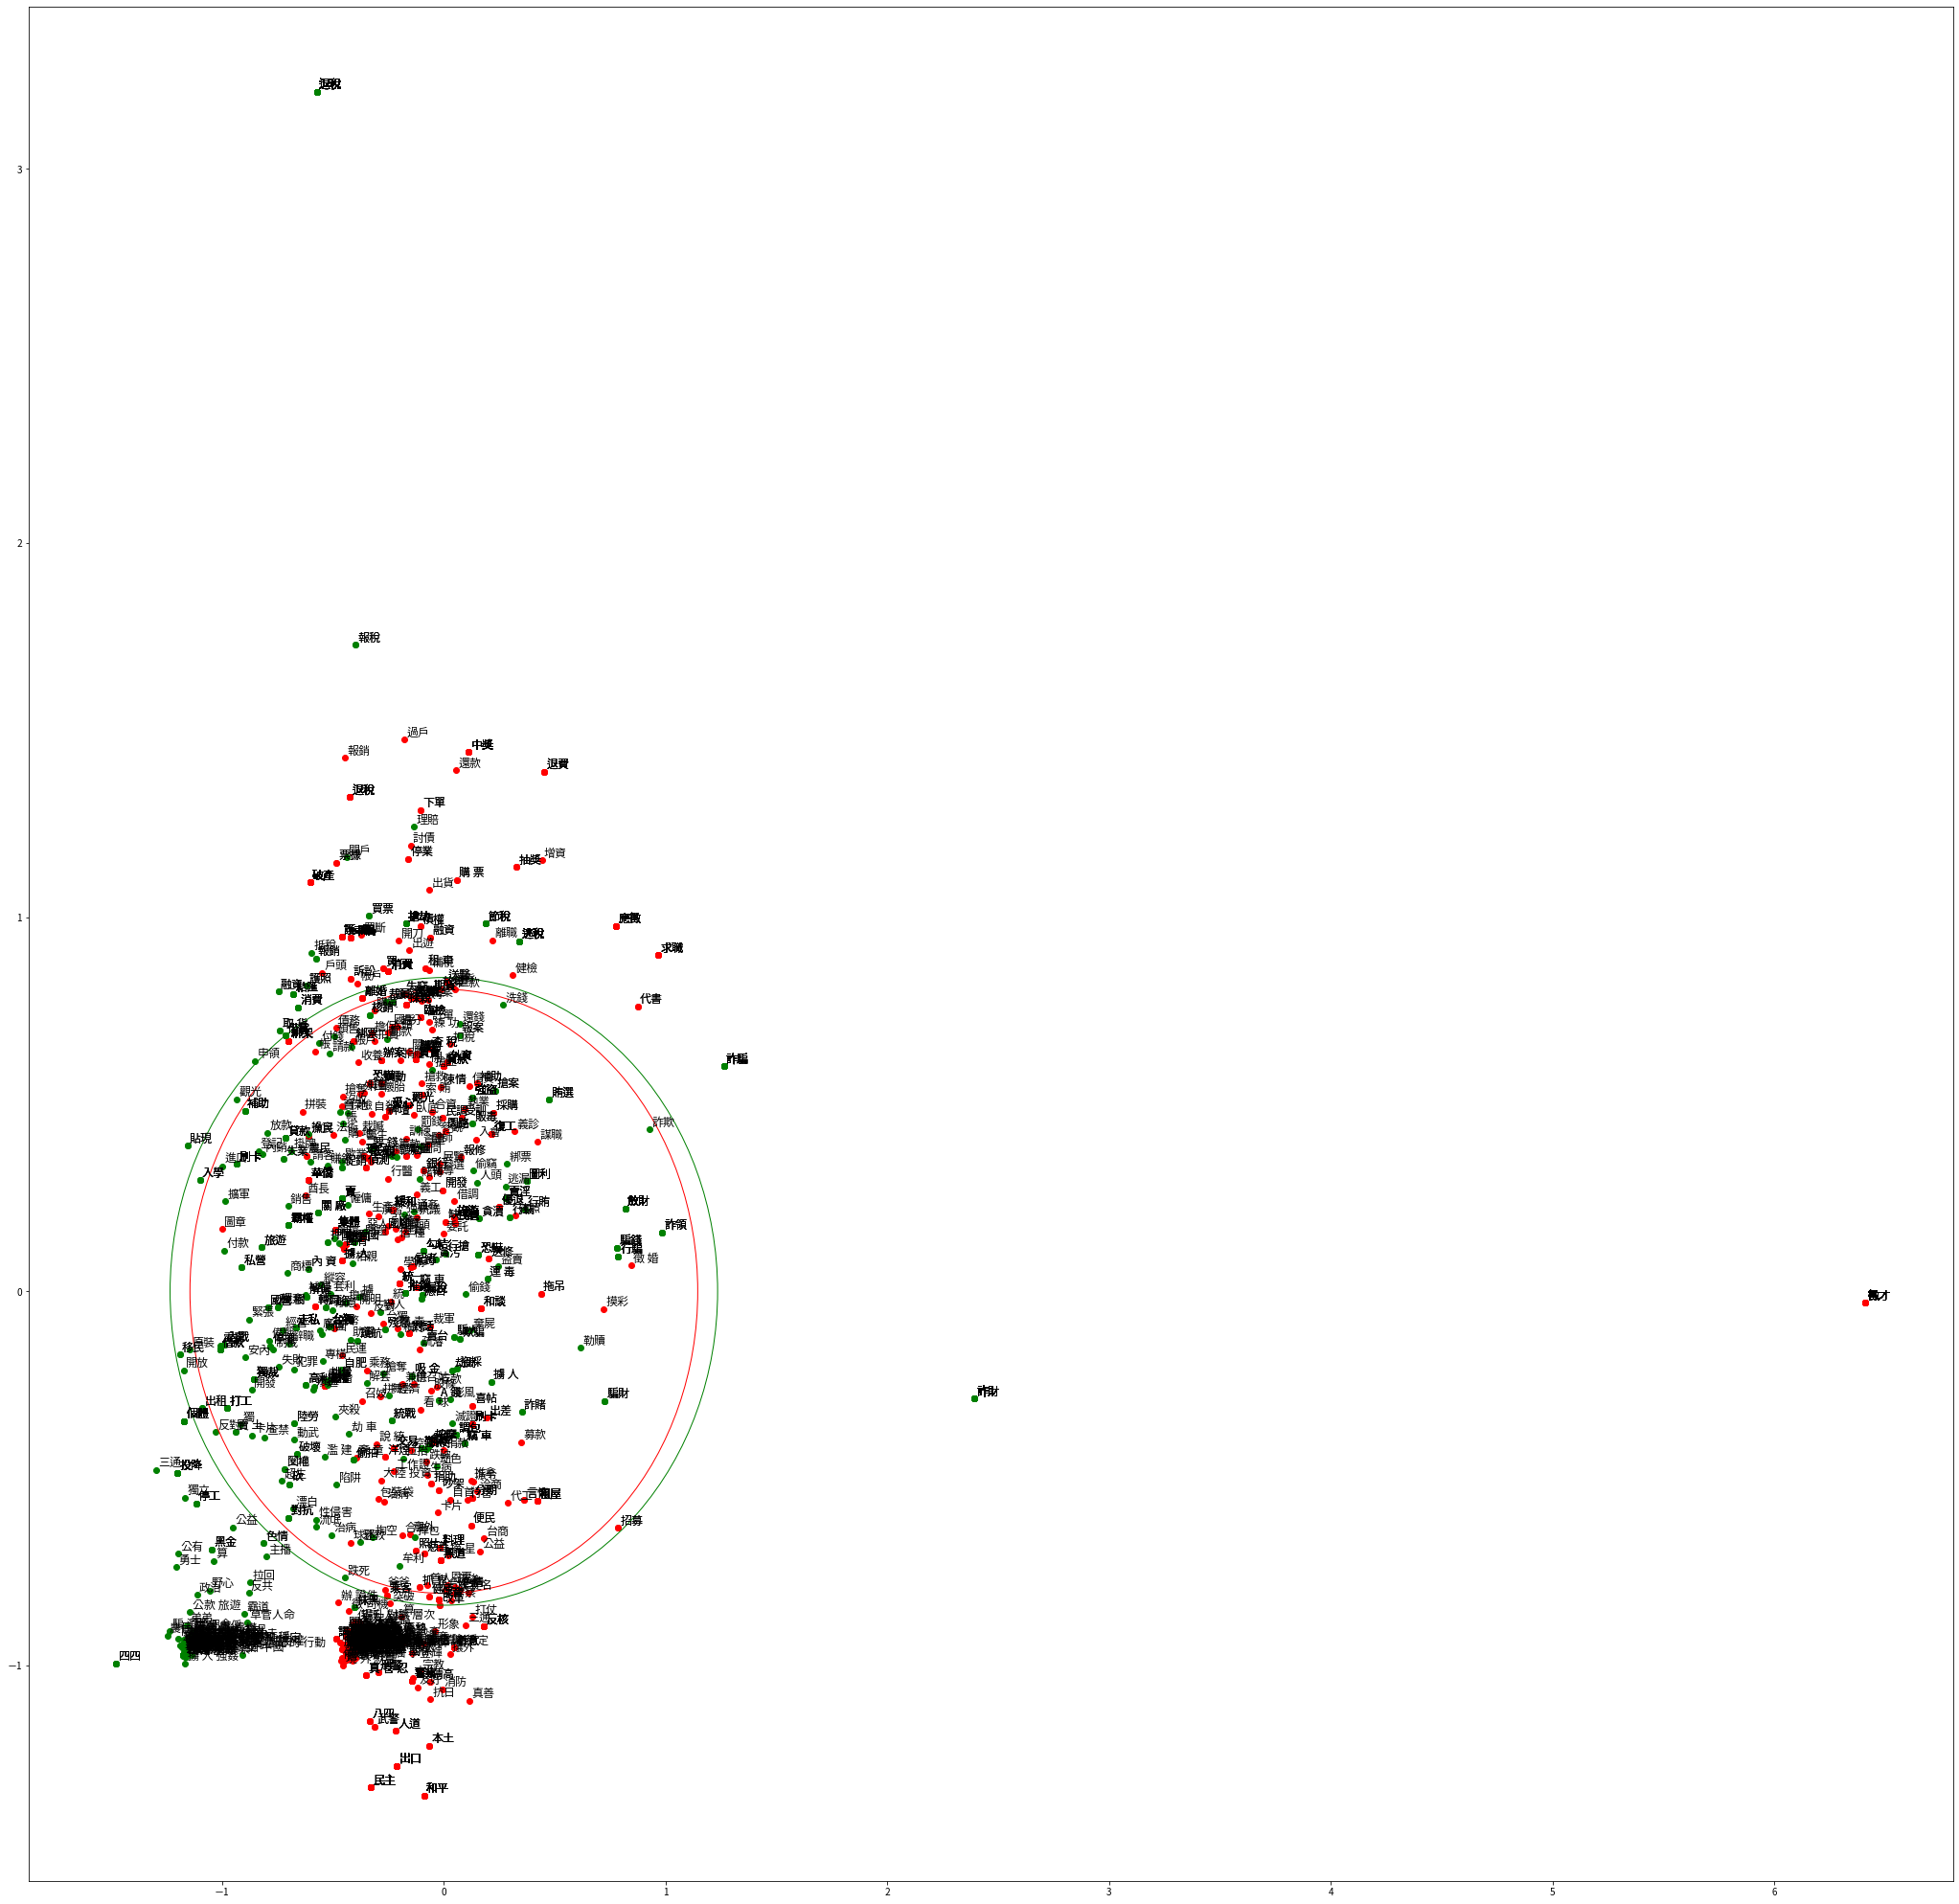

<Figure size 432x288 with 0 Axes>

In [20]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import numpy as np

figzoom, axzoom = plt.subplots(figsize = (36,36))

axzoom.scatter(pca_df_X_ft["X"], pca_df_X_ft["Y"], c = "red")
confidence_ellipse(pca_df_X_ft["X"], pca_df_X_ft["Y"], axzoom, n_std = 1, label = r'$1\sigma$', edgecolor = 'red')
for i, label in enumerate(pca_df_X_ft.index.to_list()):
    axzoom.annotate(label, (pca_df_X_ft["X"][i]+0.01, pca_df_X_ft["Y"][i]+0.01), fontsize = 12)

axzoom.scatter(pca_df_Y_ft["X"], pca_df_Y_ft["Y"], c = "green")
confidence_ellipse(pca_df_Y_ft["X"], pca_df_Y_ft["Y"], axzoom, n_std = 1, label = r'$1\sigma$', edgecolor = 'green')
for i, label in enumerate(pca_df_Y_ft.index.to_list()):
    axzoom.annotate(label, (pca_df_Y_ft["X"][i]+0.01, pca_df_Y_ft["Y"][i]+0.01), fontsize = 12)

plt.show()

plt.savefig("fig_pretrained.jpg")

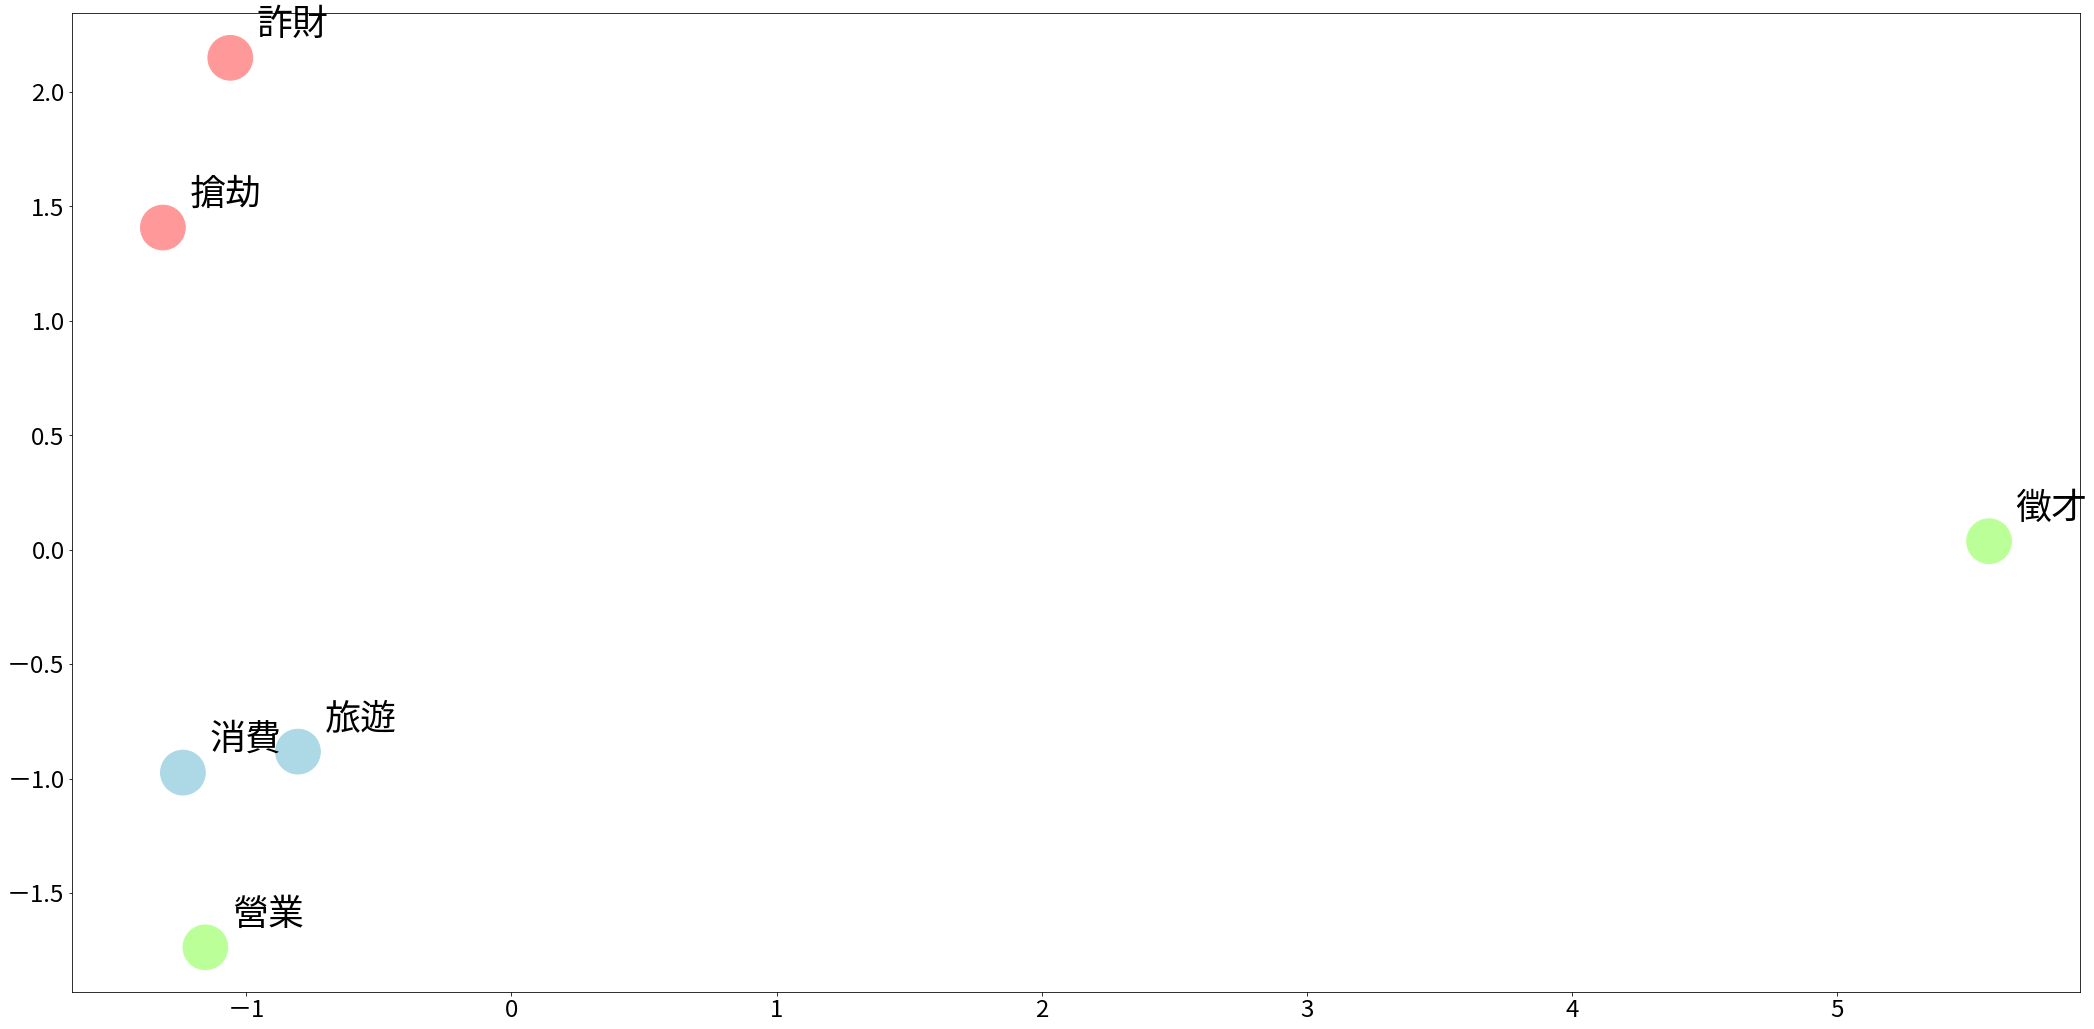

In [21]:
# select a few representative words
wd_ls = ['營業', '徵才', '搶劫', '詐財', '消費' ,'旅遊']
cl_ls = ['#BBFF99', '#BBFF99', '#FF9999', '#FF9999', '#ADD8E6', '#ADD8E6']

vec_ls_ft = []
for words in wd_ls:
  vec_ls_ft.append(ft.get_word_vector(words))
vec_df_ft = pd.DataFrame(vec_ls_ft, index=wd_ls)

pca_matrix_ft = pca.fit(vec_df_ft).transform(vec_df_ft)
pca_df_ft = pd.DataFrame(pca_matrix_ft)
pca_df_ft = pca_df_ft.set_axis(["X_pre", "Y_pre"], axis=1)
pca_df_ft.index = vec_df_ft.index.to_list()

figzoom, axzoom = plt.subplots(figsize = (36,18))
axzoom.tick_params(labelsize=24)

axzoom.scatter(pca_df_ft["X_pre"], pca_df_ft["Y_pre"], c = cl_ls, s = 2000)
for i, label in enumerate(pca_df_ft.index.to_list()):
    axzoom.annotate(label, (pca_df_ft["X_pre"][i]+0.1, pca_df_ft["Y_pre"][i]+0.1), fontsize = 36)
plt.show()

# 4 *jia X zhen Y* FastText Model

## 4.1 Word segmentation by CKIPtagger

In [22]:
# remove pretrained FastText model to save RAM
try: 
  del(ft)
except:
  print("FatText model already removed.")

In [23]:
from google.colab import drive
drive.mount('/content/drive')

!wget -P /content/drive/MyDrive/NTU_Studies/2021_Fall

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
wget: missing URL
Usage: wget [OPTION]... [URL]...

Try `wget --help' for more options.


In [24]:
!pip install ckiptagger 
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER

ws = WS("/content/drive/MyDrive/NTU_Studies/2021_Fall/Computational Semantics/Term Paper/data")

/usr/local/lib/python3.7/dist-packages/ckiptagger/model_ws.py:106: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:988: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  partitioner=maybe_partitioner)
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:996: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  initializer=initializer)


In [25]:
ls= []
for i in data.iterrows(): 
    x_rm = re.sub(' ', '', i[1]['X'])
    y_rm = re.sub(' ', '', i[1]['Y']) 
    ls.append(x_rm)
    ls.append(y_rm)
# print(ls)

word_dic = dict()
for i in ls:
    word_dic[i] = ls.count(i)

print(len(word_dic))
dictionary = construct_dictionary(word_dic)
print(dictionary)

576
[(1, {'砍': 3.0, '買': 2.0, '賣': 7.0, '擄': 1.0, '帳': 2.0, '算': 2.0, '男': 1.0, '女': 1.0, '統': 1.0, '獨': 1.0}), (2, {'外資': 7.0, '逃稅': 16.0, '華僑': 10.0, '進口': 16.0, '結匯': 5.0, '存款': 1.0, '領款': 1.0, '依親': 6.0, '打工': 7.0, '消費': 57.0, '申領': 1.0, '漏稅': 4.0, '農民': 2.0, '警察': 13.0, '搶匪': 1.0, '展覽': 1.0, '掉包': 1.0, '車禍': 32.0, '搶劫': 33.0, '臨檢': 7.0, '詐財': 173.0, '投資': 11.0, '爸爸': 1.0, '弟弟': 1.0, '逃漏': 1.0, '保育': 6.0, '開發': 3.0, '購地': 1.0, '問題': 1.0, '緊張': 1.0, '義診': 1.0, '綁架': 12.0, '出口': 50.0, '退稅': 44.0, '押匯': 2.0, '出差': 2.0, '核銷': 3.0, '探親': 6.0, '統戰': 3.0, '棄童': 1.0, '報案': 2.0, '觀光': 5.0, '受訓': 2.0, '陸勞': 2.0, '買賣': 8.0, '贈與': 1.0, '看球': 1.0, '移民': 2.0, '買斷': 1.0, '抓鬼': 2.0, '賄選': 3.0, '跌破': 1.0, '洗盤': 1.0, '強盜': 14.0, '罰錢': 1.0, '內銷': 1.0, '合資': 1.0, '走私': 14.0, '調包': 5.0, '獅頭': 1.0, '人頭': 2.0, '離職': 1.0, '領錢': 2.0, '放款': 1.0, '借款': 9.0, '失竊': 2.0, '盜賣': 1.0, '融資': 4.0, '劫車': 1.0, '勒索': 10.0, '武警': 2.0, '海盜': 2.0, '和平': 17.0, '投降': 10.0, '搶案': 3.0, '演習': 1.0, '動武': 1.0, '緩和': 9.0, '台獨': 2

In [26]:
# see if collecting into one big dictionary and changing to larger weights help
dict_ls = []
for i in dictionary:
    # print(i[0])
    dict_temp = dict()
    for j in i[1]:
        dict_temp[j] = i[1][j]*int(i[0])**2
        # print(i[1][j], dict_temp[j])
    tp = (i[0], dict_temp)
    dict_ls.append(tp)

print(dict_ls)

[(1, {'砍': 3.0, '買': 2.0, '賣': 7.0, '擄': 1.0, '帳': 2.0, '算': 2.0, '男': 1.0, '女': 1.0, '統': 1.0, '獨': 1.0}), (2, {'外資': 28.0, '逃稅': 64.0, '華僑': 40.0, '進口': 64.0, '結匯': 20.0, '存款': 4.0, '領款': 4.0, '依親': 24.0, '打工': 28.0, '消費': 228.0, '申領': 4.0, '漏稅': 16.0, '農民': 8.0, '警察': 52.0, '搶匪': 4.0, '展覽': 4.0, '掉包': 4.0, '車禍': 128.0, '搶劫': 132.0, '臨檢': 28.0, '詐財': 692.0, '投資': 44.0, '爸爸': 4.0, '弟弟': 4.0, '逃漏': 4.0, '保育': 24.0, '開發': 12.0, '購地': 4.0, '問題': 4.0, '緊張': 4.0, '義診': 4.0, '綁架': 48.0, '出口': 200.0, '退稅': 176.0, '押匯': 8.0, '出差': 8.0, '核銷': 12.0, '探親': 24.0, '統戰': 12.0, '棄童': 4.0, '報案': 8.0, '觀光': 20.0, '受訓': 8.0, '陸勞': 8.0, '買賣': 32.0, '贈與': 4.0, '看球': 4.0, '移民': 8.0, '買斷': 4.0, '抓鬼': 8.0, '賄選': 12.0, '跌破': 4.0, '洗盤': 4.0, '強盜': 56.0, '罰錢': 4.0, '內銷': 4.0, '合資': 4.0, '走私': 56.0, '調包': 20.0, '獅頭': 4.0, '人頭': 8.0, '離職': 4.0, '領錢': 8.0, '放款': 4.0, '借款': 36.0, '失竊': 8.0, '盜賣': 4.0, '融資': 16.0, '劫車': 4.0, '勒索': 40.0, '武警': 8.0, '海盜': 8.0, '和平': 68.0, '投降': 40.0, '搶案': 12.0, '演習': 4.0, '動武': 4.0,

In [27]:
no_space= []
for i in data['cleaned']:
    no_space.append(i.replace(" ", ''))

data['no_space'] = no_space

In [28]:
word_sentence_list_tgr = ws(
    data['no_space'],
    # sentence_segmentation = False, # To consider delimiters
    # segment_delimiter_set = {",", "。", ":", "?", "!", ";"}, # This is the defualt set of delimiters
    # recommend_dictionary = dict_ls, # words in this dictionary are encouraged
    coerce_dictionary = dict_ls # words in this dictionary are forced
)

In [29]:
word_sentence_list_tgr[10]

['成人', '冒認', '在', '台', '親屬', '來', '台', '假', '依親', '真', '打工', '的', '案件']

## 4.2 FastText model

In [30]:
## train model
!pip install --upgrade gensim
from gensim.models import FastText

model = FastText(vector_size = 300, min_count = 1)  # instantiate
model.build_vocab(word_sentence_list_tgr)
model.train(word_sentence_list_tgr, total_examples = len(word_sentence_list_tgr), epochs = 100)  # train

wv = model.wv

print(wv)

print(len(wv["依親"]))
print('依親' in wv.key_to_index)

     |████████████████████████████████| 24.1 MB 14 kB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
300
True


## 4.3 Construction matrix


In [31]:
vec_ls_tgr = []

for i in data.iterrows():
    vec_X = wv[i[1]['X'].replace(' ', '')]
    vec_Y = wv[i[1]['Y'].replace(' ', '')]

    ls = [vec_X, vec_Y]
    vec_ls_tgr.append(ls)

In [32]:
vec_df_tgr = pd.DataFrame(vec_ls_tgr)
vec_df_tgr = vec_df_tgr.rename(columns = {0:'X_vec', 1:'Y_vec'})
vec_df_tgr.head(5)

,X_vec,Y_vec
0,"[-0.23128836, 0.25001633, -0.3967351, 0.273654...","[-0.20988043, 0.16798985, -0.3655928, 0.196496..."
1,"[0.06285292, 0.46482915, -0.047111146, 0.28419...","[-0.20988043, 0.16798985, -0.3655928, 0.196496..."
2,"[0.06285292, 0.46482915, -0.047111146, 0.28419...","[-0.20988043, 0.16798985, -0.3655928, 0.196496..."
3,"[0.75768477, -0.51892567, -0.2008276, 0.109325...","[0.34377795, -0.16896944, -0.050923847, 0.0779..."
4,"[0.75768477, -0.51892567, -0.2008276, 0.109325...","[0.34377795, -0.16896944, -0.050923847, 0.0779..."


In [33]:
X_vec_df_tgr = pd.DataFrame(vec_df_tgr['X_vec'].to_list())
X = pd.DataFrame(data['X'])
X_vec_df_tgr = X_vec_df_tgr.join(X).set_index('X')

Y_vec_df_tgr = pd.DataFrame(vec_df_tgr['Y_vec'].to_list())
Y = pd.DataFrame(data['Y'])
Y_vec_df_tgr = Y_vec_df_tgr.join(Y).set_index('Y')

## 4.4 PCA to lower dimensions

In [34]:
# PCA to two dimensions
from sklearn.decomposition import PCA

pca_matrix_X_tgr = pca.fit(X_vec_df_tgr).transform(X_vec_df_tgr)
pca_df_X_tgr = pd.DataFrame(pca_matrix_X_tgr)
pca_df_X_tgr = pca_df_X_tgr.set_axis(["X", "Y"], axis=1)
pca_df_X_tgr.index = X_vec_df_tgr.index.to_list()

pca_matrix_Y_tgr = pca.fit(Y_vec_df_tgr).transform(Y_vec_df_tgr)
pca_df_Y_tgr = pd.DataFrame(pca_matrix_Y_tgr)
pca_df_Y_tgr = pca_df_Y_tgr.set_axis(["X", "Y"], axis=1)
pca_df_Y_tgr.index = Y_vec_df_tgr.index.to_list()

## 4.5 Plot

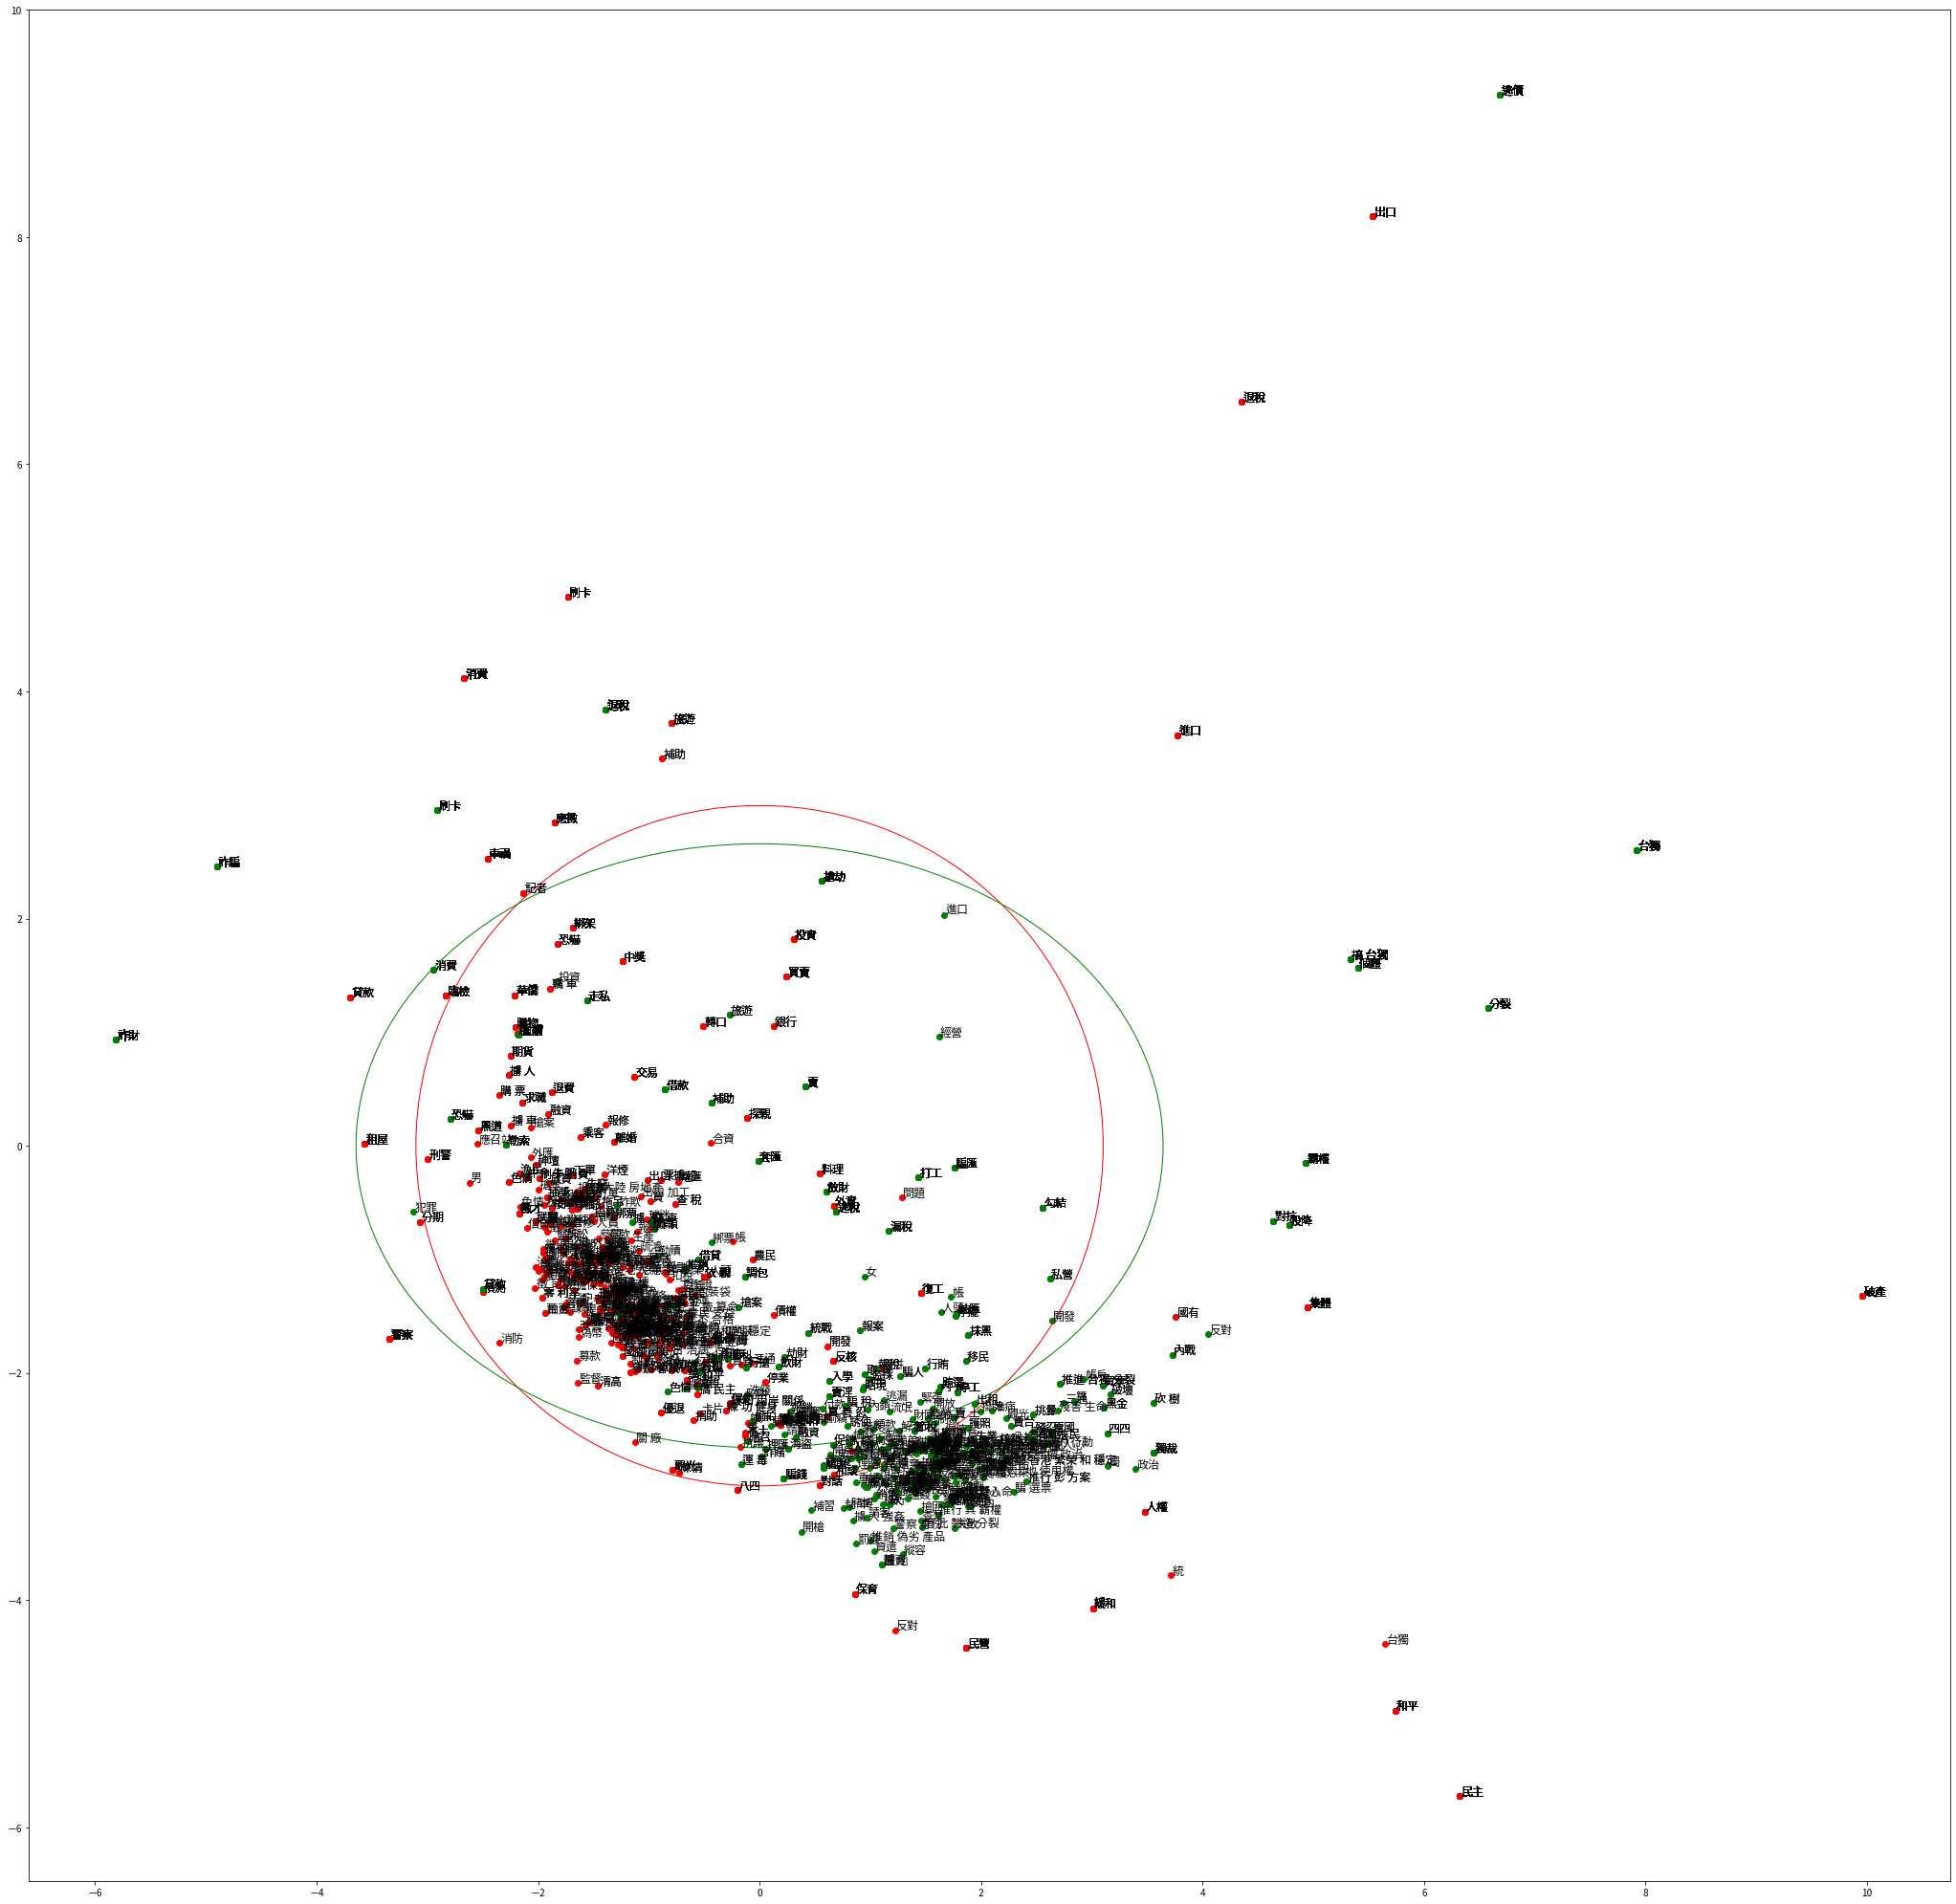

<Figure size 432x288 with 0 Axes>

In [35]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import numpy as np

figzoom, axzoom = plt.subplots(figsize = (36,36))

axzoom.scatter(pca_df_X_tgr["X"], pca_df_X_tgr["Y"], c = "red")
confidence_ellipse(pca_df_X_tgr["X"], pca_df_X_tgr["Y"], axzoom, n_std = 1, label = r'$1\sigma$', edgecolor = 'red')
for i, label in enumerate(pca_df_X_tgr.index.to_list()):
    axzoom.annotate(label, (pca_df_X_tgr["X"][i]+0.01, pca_df_X_tgr["Y"][i]+0.01), fontsize = 12)

axzoom.scatter(pca_df_Y_tgr["X"], pca_df_Y_tgr["Y"], c = "green")
confidence_ellipse(pca_df_Y_tgr["X"], pca_df_Y_tgr["Y"], axzoom, n_std = 1, label = r'$1\sigma$', edgecolor = 'green')
for i, label in enumerate(pca_df_Y_tgr.index.to_list()):
    axzoom.annotate(label, (pca_df_Y_tgr["X"][i]+0.01, pca_df_Y_tgr["Y"][i]+0.01), fontsize = 12)

plt.show()

plt.savefig("fig_jiaXzhenY.jpg")

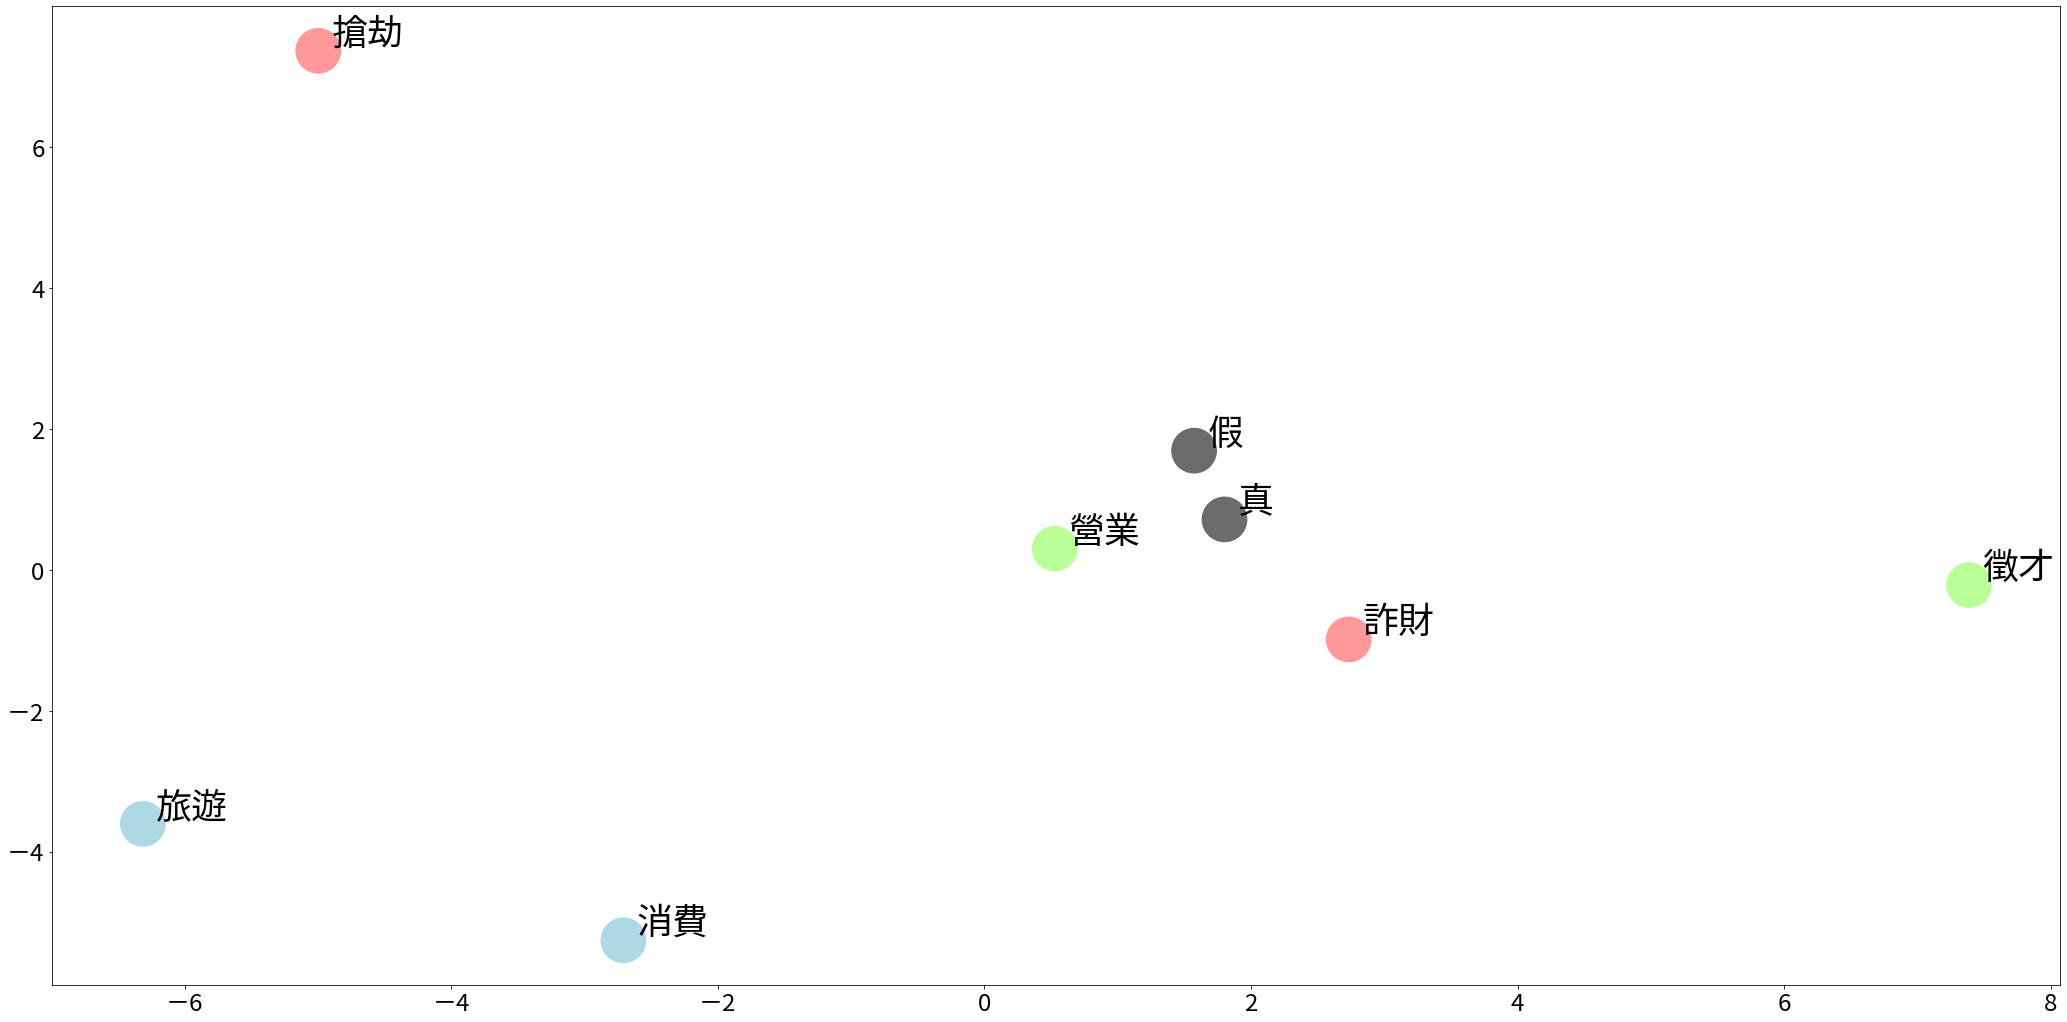

In [36]:
# select a few representative words
wd_ls = ['假', '真', '營業', '徵才', '搶劫', '詐財', '消費' ,'旅遊']
cl_ls = ['#6B6B6B', '#6B6B6B', '#BBFF99', '#BBFF99', '#FF9999', '#FF9999', '#ADD8E6', '#ADD8E6']

vec_ls_tgr = []
for words in wd_ls:
  vec_ls_tgr.append(wv[words])
vec_df_tgr = pd.DataFrame(vec_ls_tgr, index=wd_ls)
# print(vec_df_tgr)

pca_matrix_tgr = pca.fit(vec_df_tgr).transform(vec_df_tgr)
pca_df_tgr = pd.DataFrame(pca_matrix_tgr)
pca_df_tgr = pca_df_tgr.set_axis(["X_tgr", "Y_tgr"], axis=1)
pca_df_tgr.index = vec_df_tgr.index.to_list()
# print(pca_df_tgr)

figzoom, axzoom = plt.subplots(figsize = (36,18))
axzoom.tick_params(labelsize=24)

axzoom.scatter(pca_df_tgr["X_tgr"], pca_df_tgr["Y_tgr"], c = cl_ls, s = 2000)
for i, label in enumerate(pca_df_tgr.index.to_list()):
    axzoom.annotate(label, (pca_df_tgr["X_tgr"][i]+0.1, pca_df_tgr["Y_tgr"][i]+0.1), fontsize = 36)
plt.show()


# 5 OOV *X* OOV *Y* FastText Model

## 5.1 Clean and tokenize text

In [37]:
oov_ls = []
for i in word_sentence_list_tgr:
    oov_temp = []
    for text in i:
        if text == '假' or text == '真':
          text = 'OOV'
        oov_temp.append(text)
    oov_ls.append(oov_temp)    
print(oov_ls[0:5])

[['另', '賦稅署', '去年', '查獲', 'OOV', '外資', 'OOV', '逃稅', '一', '案', '成果'], ['展開', '查緝', '逃', '漏稅', '行動', '繼', 'OOV', '華僑', 'OOV', '逃稅', '案', '後', '查緝'], ['行動', '已', '一', '系列', '開展', '繼', 'OOV', '華僑', 'OOV', '逃稅', '案', '之後', '查緝'], ['鑑於', '近年', '來', '屢次', '發生', 'OOV', '進口', 'OOV', '結匯', '或', 'OOV', '進口'], ['起', '智慧型', '犯罪', '集團', '以', 'OOV', '進口', 'OOV', '結匯', '或', 'OOV', '進口']]


In [38]:
print(word_sentence_list_tgr[0:5])
print(oov_ls[0:5])

[['另', '賦稅署', '去年', '查獲', '假', '外資', '真', '逃稅', '一', '案', '成果'], ['展開', '查緝', '逃', '漏稅', '行動', '繼', '假', '華僑', '真', '逃稅', '案', '後', '查緝'], ['行動', '已', '一', '系列', '開展', '繼', '假', '華僑', '真', '逃稅', '案', '之後', '查緝'], ['鑑於', '近年', '來', '屢次', '發生', '假', '進口', '真', '結匯', '或', '真', '進口'], ['起', '智慧型', '犯罪', '集團', '以', '假', '進口', '真', '結匯', '或', '真', '進口']]
[['另', '賦稅署', '去年', '查獲', 'OOV', '外資', 'OOV', '逃稅', '一', '案', '成果'], ['展開', '查緝', '逃', '漏稅', '行動', '繼', 'OOV', '華僑', 'OOV', '逃稅', '案', '後', '查緝'], ['行動', '已', '一', '系列', '開展', '繼', 'OOV', '華僑', 'OOV', '逃稅', '案', '之後', '查緝'], ['鑑於', '近年', '來', '屢次', '發生', 'OOV', '進口', 'OOV', '結匯', '或', 'OOV', '進口'], ['起', '智慧型', '犯罪', '集團', '以', 'OOV', '進口', 'OOV', '結匯', '或', 'OOV', '進口']]


## 5.2 FastText model

In [39]:
## train model
!pip install --upgrade gensim
from gensim.models import FastText

model = FastText(vector_size = 300, min_count = 1)  # instantiate
model.build_vocab(oov_ls)
model.train(oov_ls, total_examples = len(oov_ls), epochs = 100)  # train

wv_oov = model.wv

print(wv_oov)

print(len(wv_oov["依親"]))
print('依親' in wv_oov.key_to_index)

300
True


## 5.3 Construction matrix


In [40]:
vec_ls_oov = []

for i in data.iterrows():
    vec_X = wv_oov[i[1]['X'].replace(' ', '')]
    vec_Y = wv_oov[i[1]['Y'].replace(' ', '')]

    ls = [vec_X, vec_Y]
    vec_ls_oov.append(ls)

In [41]:
vec_df_oov = pd.DataFrame(vec_ls_oov)
vec_df_oov = vec_df_oov.rename(columns = {0:'X_vec', 1:'Y_vec'})

In [42]:
X_vec_df_oov = pd.DataFrame(vec_df_oov['X_vec'].to_list())
X = pd.DataFrame(data['X'])
X_vec_df_oov = X_vec_df_oov.join(X).set_index('X')

Y_vec_df_oov = pd.DataFrame(vec_df_oov['Y_vec'].to_list())
Y = pd.DataFrame(data['Y'])
Y_vec_df_oov = Y_vec_df_oov.join(Y).set_index('Y')

## 5.4 PCA to lower dimensions

In [43]:
# PCA to two dimensions
from sklearn.decomposition import PCA

pca_matrix_X_oov = pca.fit(X_vec_df_oov).transform(X_vec_df_oov)
pca_df_X_oov = pd.DataFrame(pca_matrix_X_oov)
pca_df_X_oov = pca_df_X_oov.set_axis(["X", "Y"], axis=1)
pca_df_X_oov.index = X_vec_df_oov.index.to_list()

pca_matrix_Y_oov = pca.fit(Y_vec_df_oov).transform(Y_vec_df_oov)
pca_df_Y_oov = pd.DataFrame(pca_matrix_Y_oov)
pca_df_Y_oov = pca_df_Y_oov.set_axis(["X", "Y"], axis=1)
pca_df_Y_oov.index = Y_vec_df_oov.index.to_list()

## 5.5 Plot

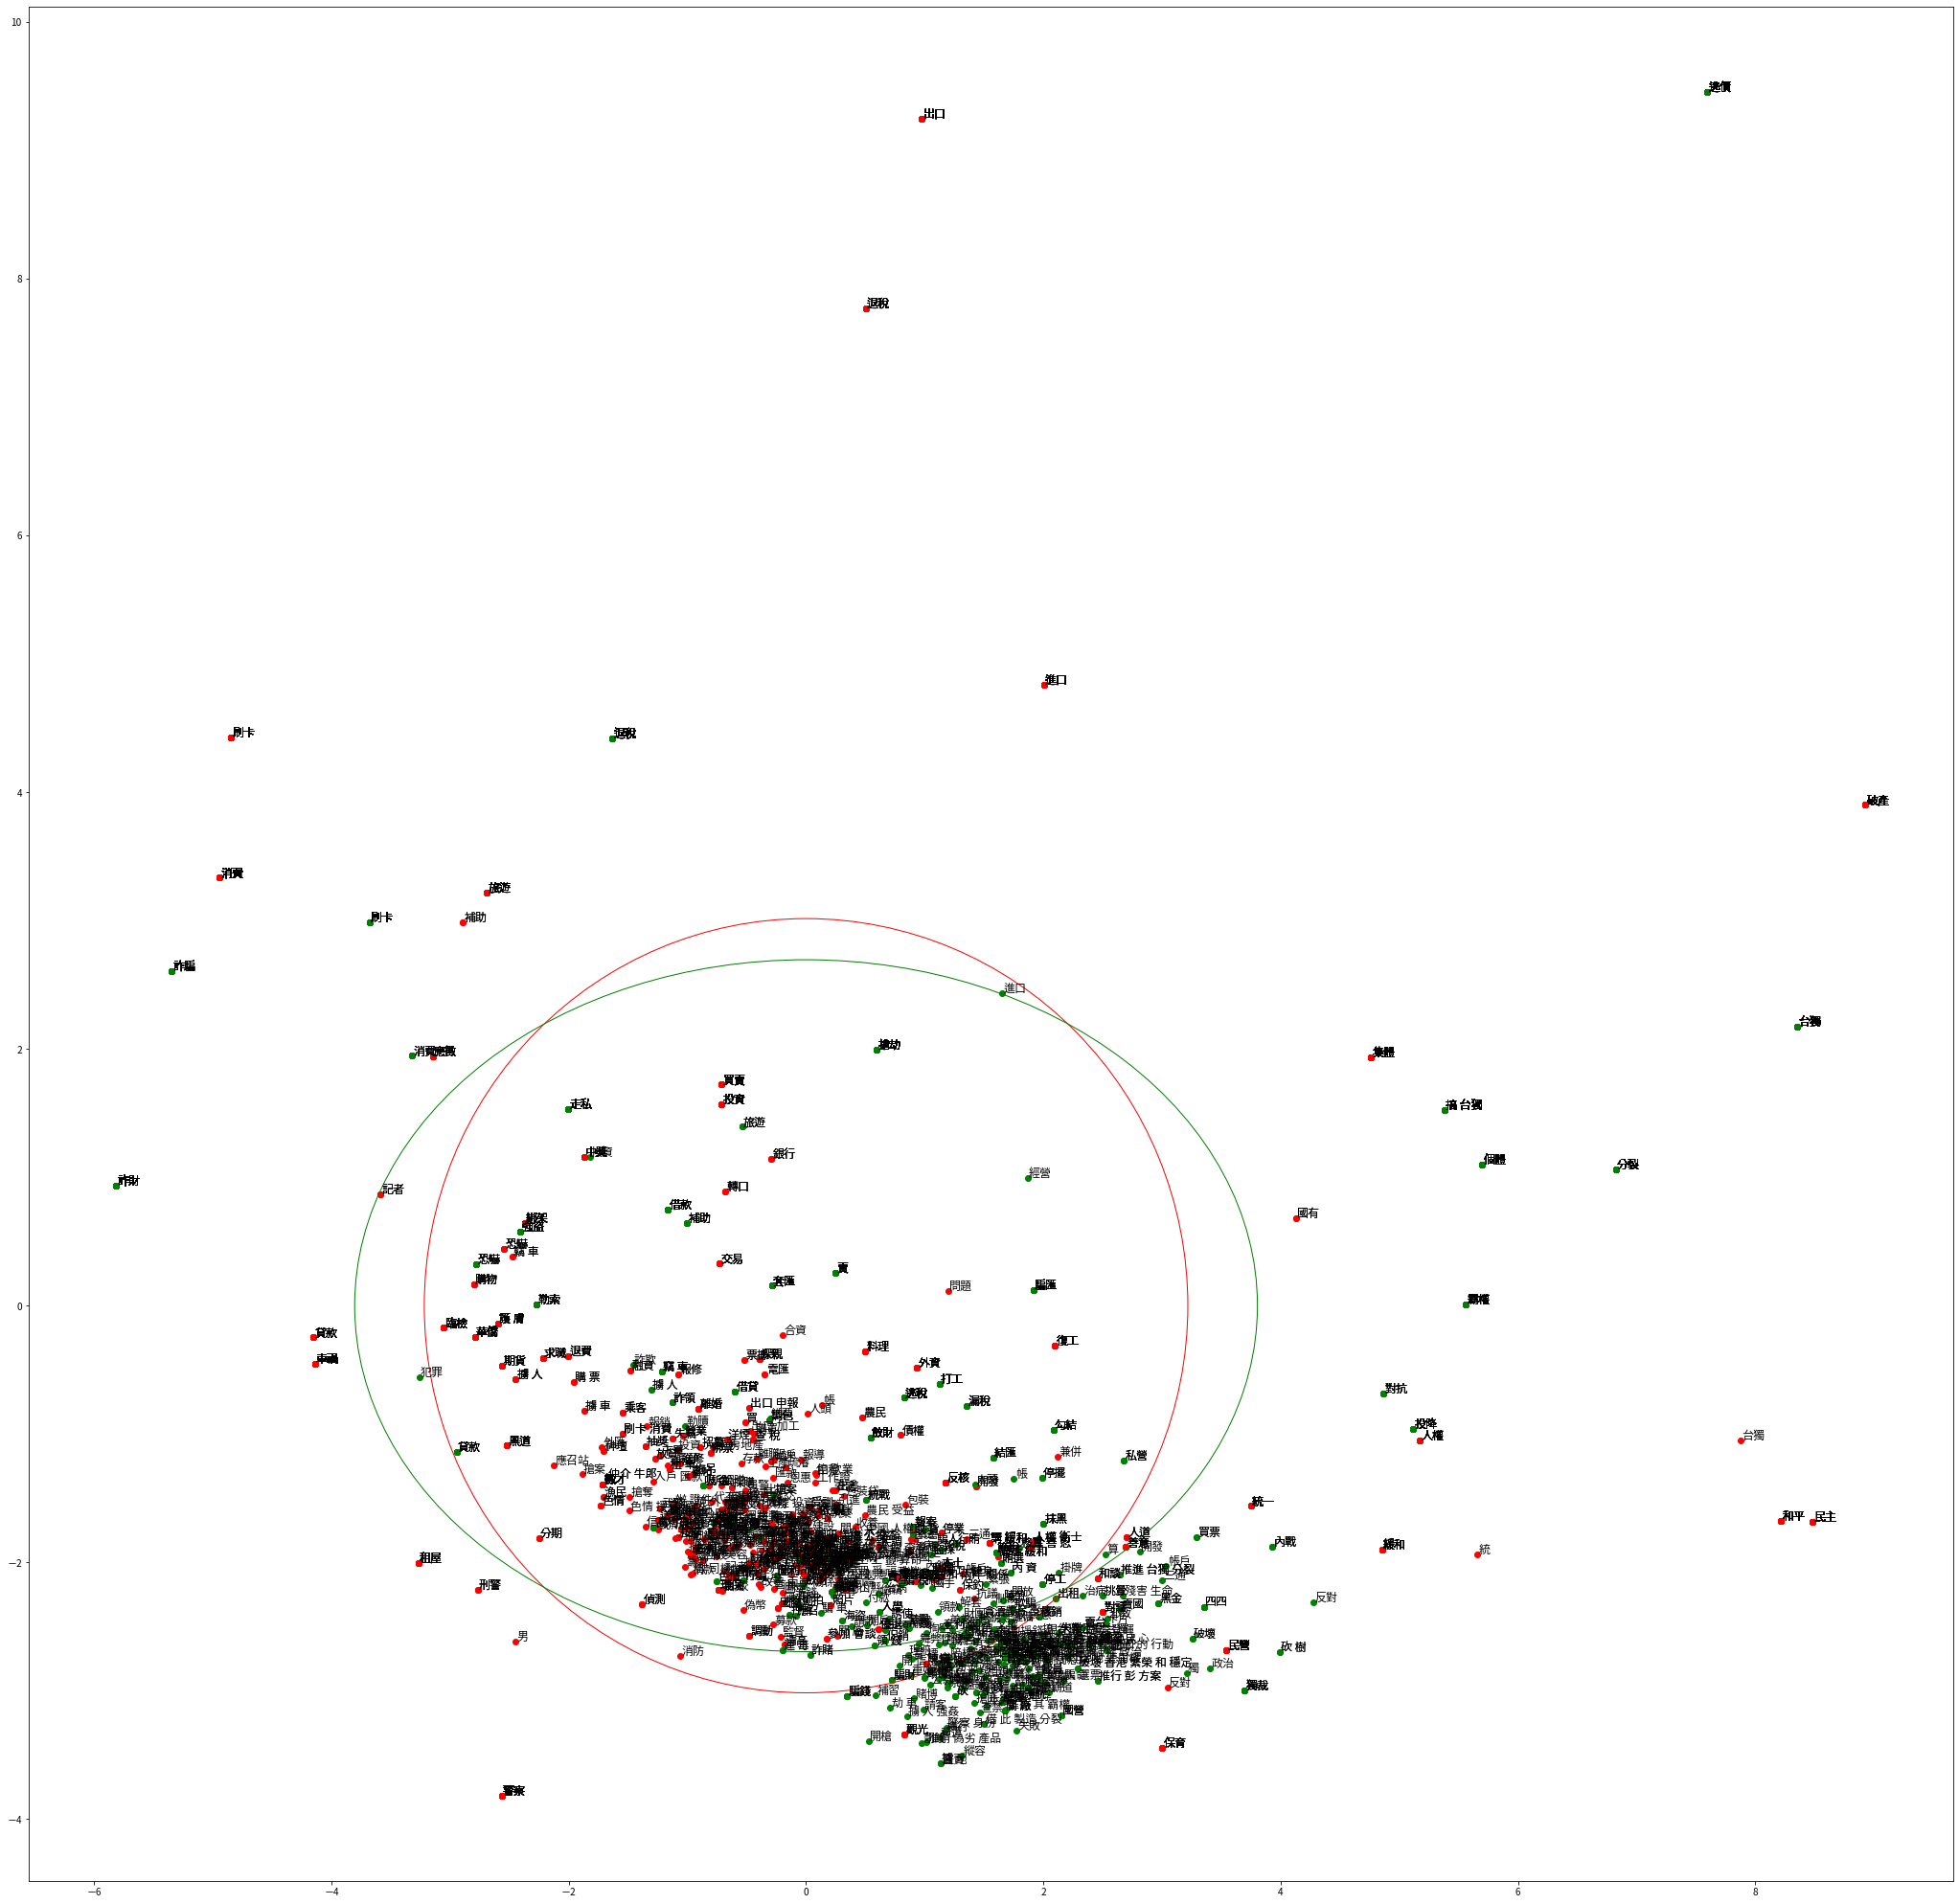

<Figure size 432x288 with 0 Axes>

In [44]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import numpy as np

figzoom, axzoom = plt.subplots(figsize = (36,36))

axzoom.scatter(pca_df_X_oov["X"], pca_df_X_oov["Y"], c = "red")
confidence_ellipse(pca_df_X_oov["X"], pca_df_X_oov["Y"], axzoom, n_std = 1, label = r'$1\sigma$', edgecolor = 'red')
for i, label in enumerate(pca_df_X_oov.index.to_list()):
    axzoom.annotate(label, (pca_df_X_oov["X"][i]+0.01, pca_df_X_oov["Y"][i]+0.01), fontsize = 12)

axzoom.scatter(pca_df_Y_oov["X"], pca_df_Y_oov["Y"], c = "green")
confidence_ellipse(pca_df_Y_oov["X"], pca_df_Y_oov["Y"], axzoom, n_std = 1, label = r'$1\sigma$', edgecolor = 'green')
for i, label in enumerate(pca_df_Y_oov.index.to_list()):
    axzoom.annotate(label, (pca_df_Y_oov["X"][i]+0.01, pca_df_Y_oov["Y"][i]+0.01), fontsize = 12)

plt.show()

plt.savefig("fig_oov.jpg")

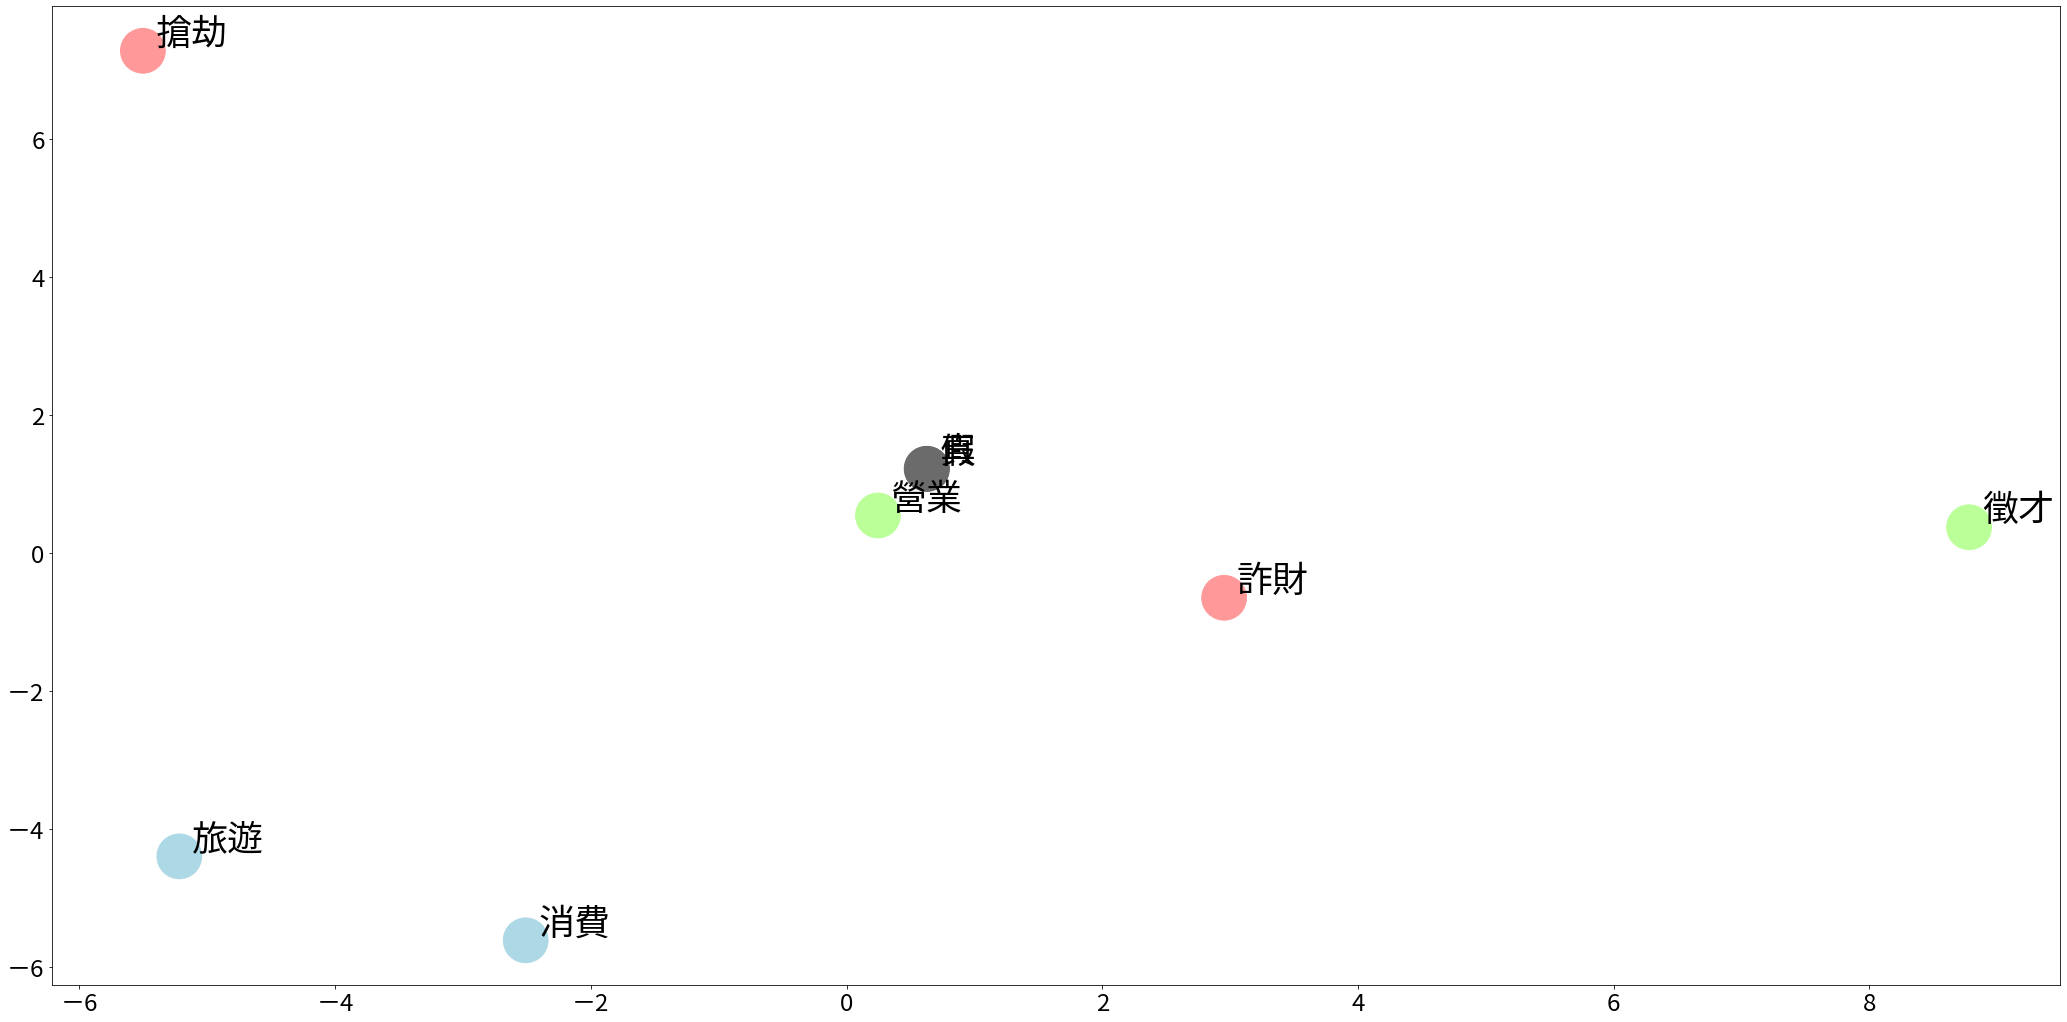

In [45]:
# select a few representative words

vec_ls_oov = []
for words in wd_ls:
  vec_ls_oov.append(wv_oov[words])
vec_df_oov = pd.DataFrame(vec_ls_oov, index=wd_ls)

pca_matrix_oov = pca.fit(vec_df_oov).transform(vec_df_oov)
pca_df_oov = pd.DataFrame(pca_matrix_oov)
pca_df_oov = pca_df_oov.set_axis(["X_oov", "Y_oov"], axis=1)
pca_df_oov.index = vec_df_oov.index.to_list()

figzoom, axzoom = plt.subplots(figsize = (36,18))
axzoom.tick_params(labelsize=24)

axzoom.scatter(pca_df_oov["X_oov"], pca_df_oov["Y_oov"], c = cl_ls, s = 2000)
for i, label in enumerate(pca_df_oov.index.to_list()):
    axzoom.annotate(label, (pca_df_oov["X_oov"][i]+0.1, pca_df_oov["Y_oov"][i]+0.1), fontsize = 36)
plt.show()

# Give RAM a break

In [46]:
del(wv, wv_oov)

# 6 *jia X jia Y* FastText Model

## 6.1 Clean and tokenize text

In [47]:
jia_ls = []
for i in word_sentence_list_tgr:
    jia_temp = []
    for text in i:
        if text == '真':
          text = '假'
        jia_temp.append(text)
    jia_ls.append(jia_temp)    
print(jia_ls[0:5])

[['另', '賦稅署', '去年', '查獲', '假', '外資', '假', '逃稅', '一', '案', '成果'], ['展開', '查緝', '逃', '漏稅', '行動', '繼', '假', '華僑', '假', '逃稅', '案', '後', '查緝'], ['行動', '已', '一', '系列', '開展', '繼', '假', '華僑', '假', '逃稅', '案', '之後', '查緝'], ['鑑於', '近年', '來', '屢次', '發生', '假', '進口', '假', '結匯', '或', '假', '進口'], ['起', '智慧型', '犯罪', '集團', '以', '假', '進口', '假', '結匯', '或', '假', '進口']]


In [48]:
print(word_sentence_list_tgr[0:5])
print(oov_ls[0:5])
print(jia_ls[0:5])

[['另', '賦稅署', '去年', '查獲', '假', '外資', '真', '逃稅', '一', '案', '成果'], ['展開', '查緝', '逃', '漏稅', '行動', '繼', '假', '華僑', '真', '逃稅', '案', '後', '查緝'], ['行動', '已', '一', '系列', '開展', '繼', '假', '華僑', '真', '逃稅', '案', '之後', '查緝'], ['鑑於', '近年', '來', '屢次', '發生', '假', '進口', '真', '結匯', '或', '真', '進口'], ['起', '智慧型', '犯罪', '集團', '以', '假', '進口', '真', '結匯', '或', '真', '進口']]
[['另', '賦稅署', '去年', '查獲', 'OOV', '外資', 'OOV', '逃稅', '一', '案', '成果'], ['展開', '查緝', '逃', '漏稅', '行動', '繼', 'OOV', '華僑', 'OOV', '逃稅', '案', '後', '查緝'], ['行動', '已', '一', '系列', '開展', '繼', 'OOV', '華僑', 'OOV', '逃稅', '案', '之後', '查緝'], ['鑑於', '近年', '來', '屢次', '發生', 'OOV', '進口', 'OOV', '結匯', '或', 'OOV', '進口'], ['起', '智慧型', '犯罪', '集團', '以', 'OOV', '進口', 'OOV', '結匯', '或', 'OOV', '進口']]
[['另', '賦稅署', '去年', '查獲', '假', '外資', '假', '逃稅', '一', '案', '成果'], ['展開', '查緝', '逃', '漏稅', '行動', '繼', '假', '華僑', '假', '逃稅', '案', '後', '查緝'], ['行動', '已', '一', '系列', '開展', '繼', '假', '華僑', '假', '逃稅', '案', '之後', '查緝'], ['鑑於', '近年', '來', '屢次', '發生', '假', '進口', '假', '結匯', '或', '假',

## 6.2 FastText model

In [49]:
## train model
!pip install --upgrade gensim
from gensim.models import FastText

model = FastText(vector_size = 300, min_count = 1)  # instantiate
model.build_vocab(oov_ls)
model.train(jia_ls, total_examples = len(jia_ls), epochs = 100)  # train

wv_jia = model.wv

print(wv_jia)

print(len(wv_jia["依親"]))
print('依親' in wv_jia.key_to_index)

300
True


## 6.3 Construction matrix


In [50]:
vec_ls_jia = []

for i in data.iterrows():
    vec_X = wv_jia[i[1]['X'].replace(' ', '')]
    vec_Y = wv_jia[i[1]['Y'].replace(' ', '')]

    ls = [vec_X, vec_Y]
    vec_ls_jia.append(ls)

In [51]:
vec_df_jia = pd.DataFrame(vec_ls_jia)
vec_df_jia = vec_df_jia.rename(columns = {0:'X_vec', 1:'Y_vec'})

In [52]:
X_vec_df_jia = pd.DataFrame(vec_df_jia['X_vec'].to_list())
X = pd.DataFrame(data['X'])
X_vec_df_jia = X_vec_df_jia.join(X).set_index('X')

Y_vec_df_jia = pd.DataFrame(vec_df_jia['Y_vec'].to_list())
Y = pd.DataFrame(data['Y'])
Y_vec_df_jia = Y_vec_df_jia.join(Y).set_index('Y')

## 6.4 PCA to lower dimensions

In [53]:
# PCA to two dimensions
from sklearn.decomposition import PCA

pca_matrix_X_jia = pca.fit(X_vec_df_jia).transform(X_vec_df_jia)
pca_df_X_jia = pd.DataFrame(pca_matrix_X_jia)
pca_df_X_jia = pca_df_X_jia.set_axis(["X", "Y"], axis=1)
pca_df_X_jia.index = X_vec_df_jia.index.to_list()

pca_matrix_Y_jia = pca.fit(Y_vec_df_jia).transform(Y_vec_df_jia)
pca_df_Y_jia = pd.DataFrame(pca_matrix_Y_jia)
pca_df_Y_jia = pca_df_Y_jia.set_axis(["X", "Y"], axis=1)
pca_df_Y_jia.index = Y_vec_df_jia.index.to_list()

## 6.5 Plot

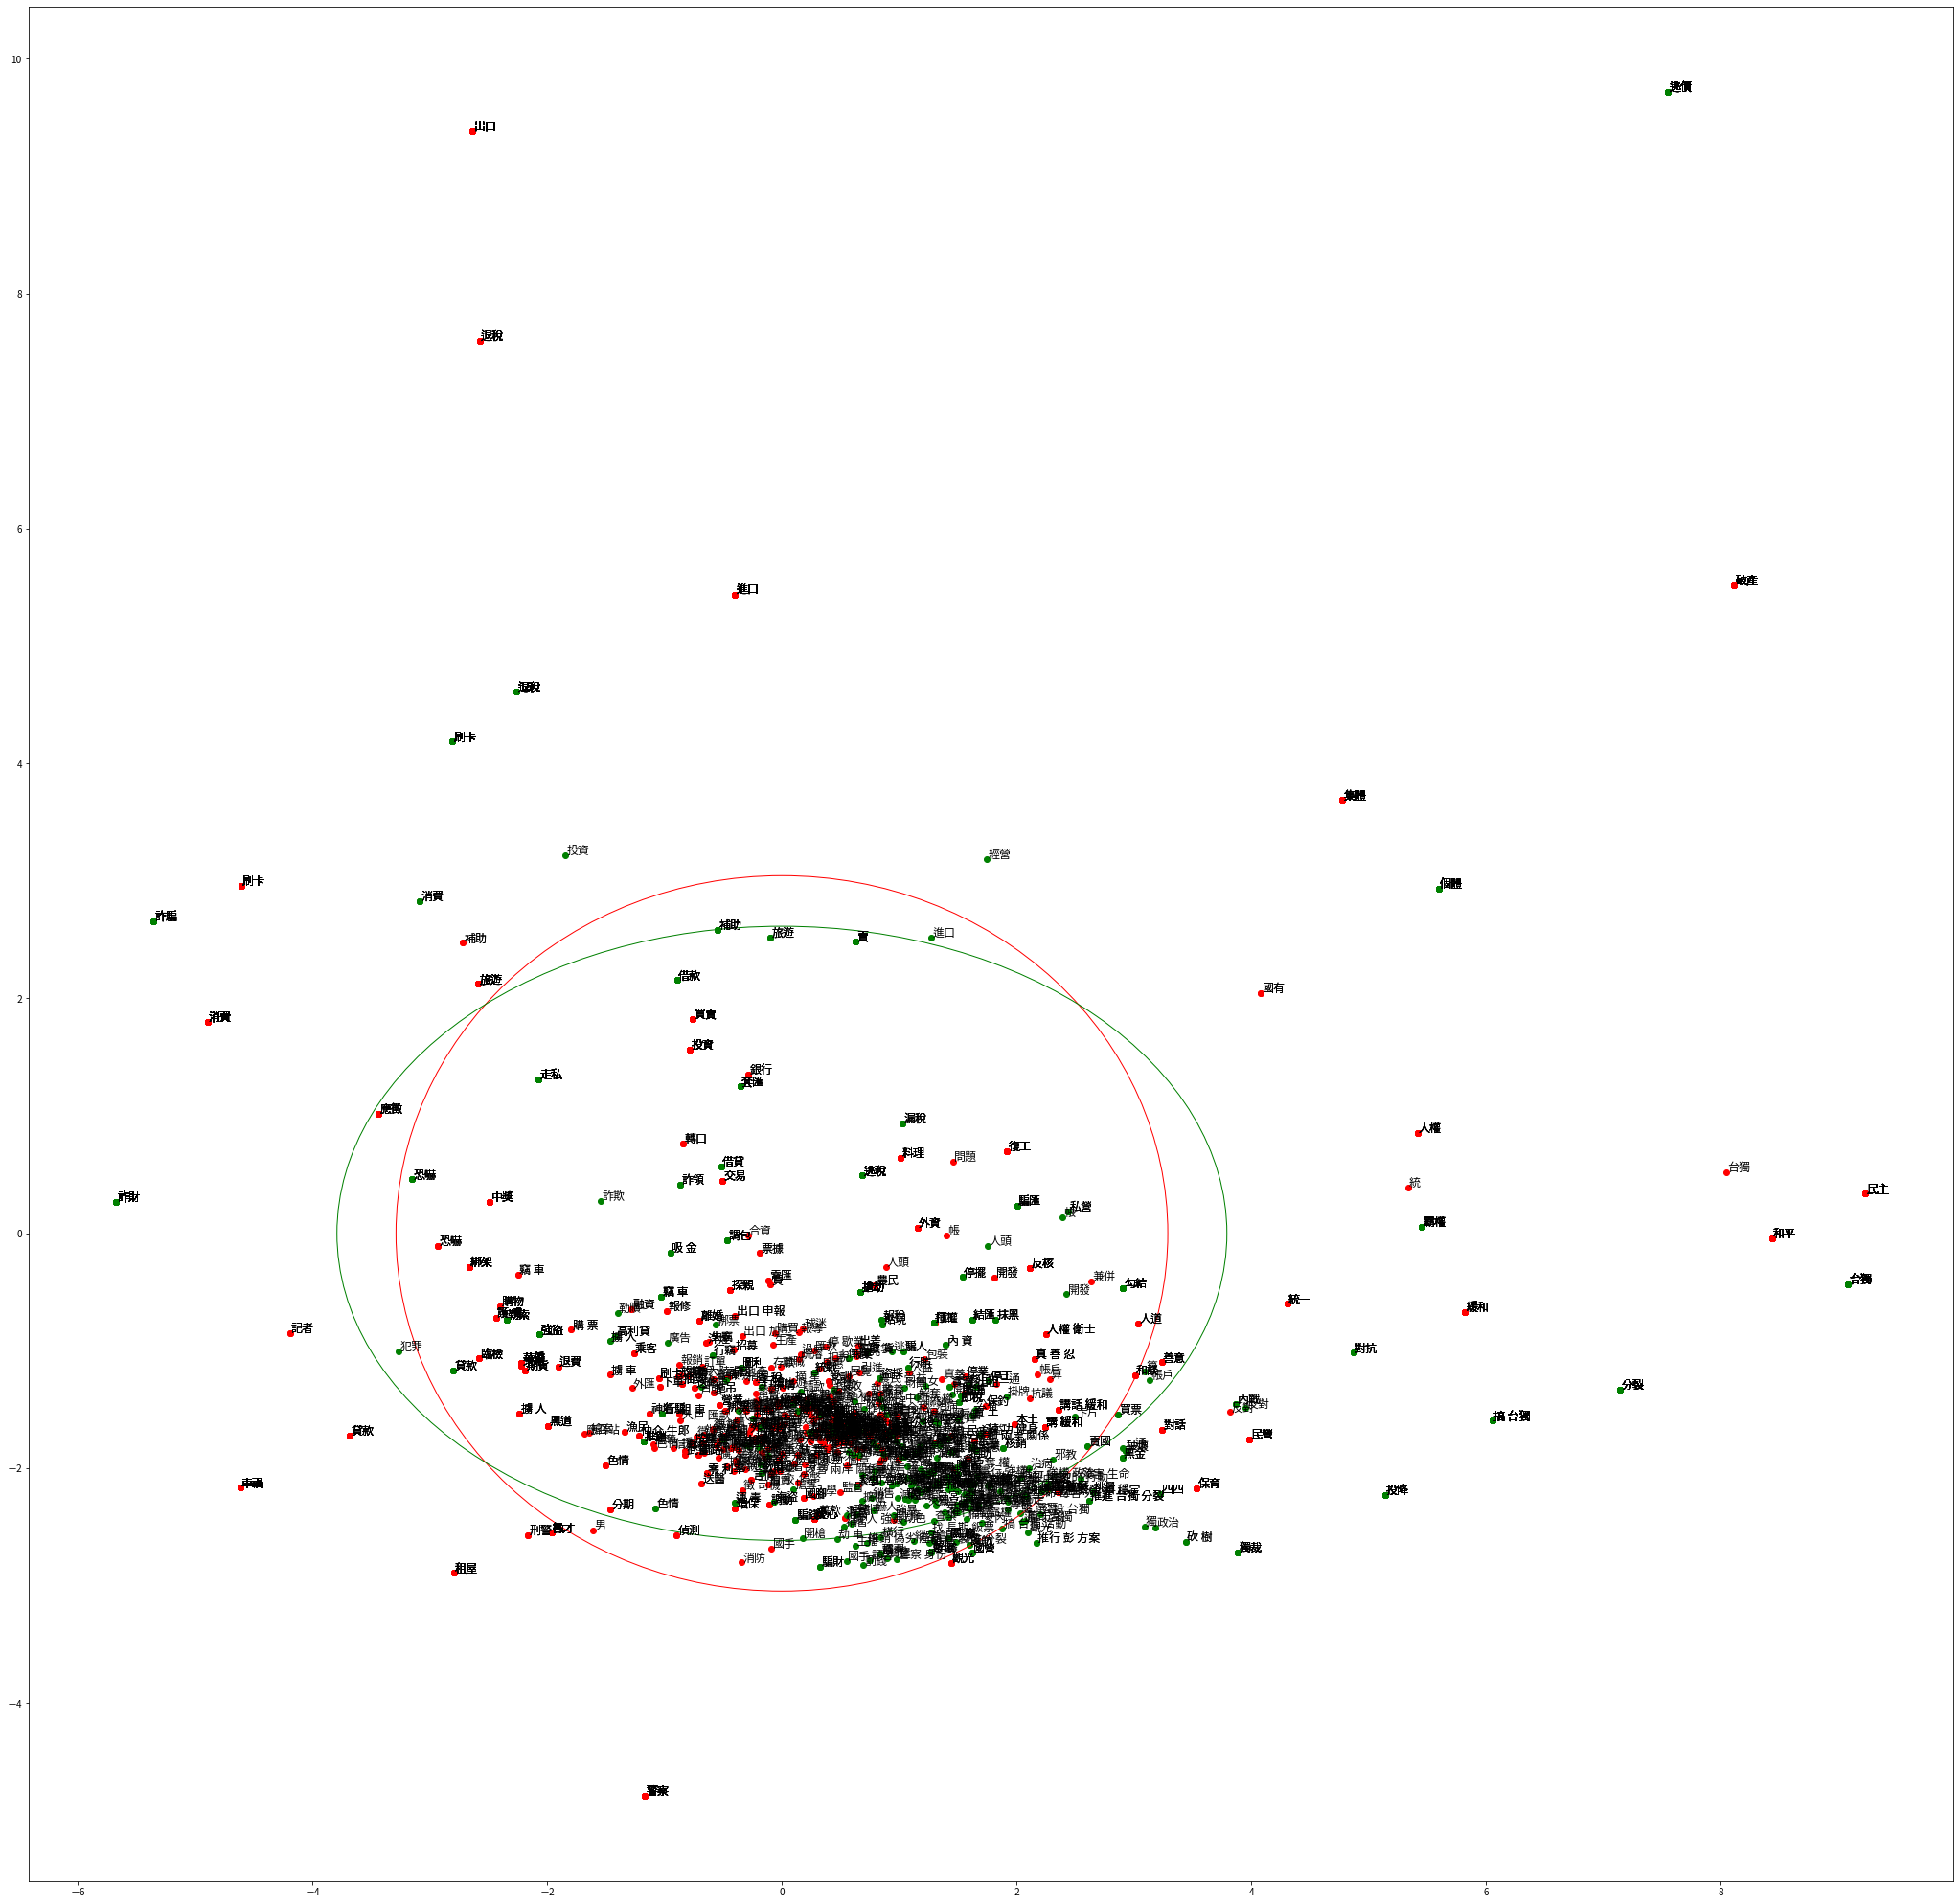

<Figure size 432x288 with 0 Axes>

In [54]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import numpy as np

figzoom, axzoom = plt.subplots(figsize = (36,36))

axzoom.scatter(pca_df_X_jia["X"], pca_df_X_jia["Y"], c = "red")
confidence_ellipse(pca_df_X_jia["X"], pca_df_X_jia["Y"], axzoom, n_std = 1, label = r'$1\sigma$', edgecolor = 'red')
for i, label in enumerate(pca_df_X_jia.index.to_list()):
    axzoom.annotate(label, (pca_df_X_jia["X"][i]+0.01, pca_df_X_jia["Y"][i]+0.01), fontsize = 12)

axzoom.scatter(pca_df_Y_jia["X"], pca_df_Y_jia["Y"], c = "green")
confidence_ellipse(pca_df_Y_jia["X"], pca_df_Y_jia["Y"], axzoom, n_std = 1, label = r'$1\sigma$', edgecolor = 'green')
for i, label in enumerate(pca_df_Y_jia.index.to_list()):
    axzoom.annotate(label, (pca_df_Y_jia["X"][i]+0.01, pca_df_Y_jia["Y"][i]+0.01), fontsize = 12)

plt.show()

plt.savefig("fig_jia.jpg")

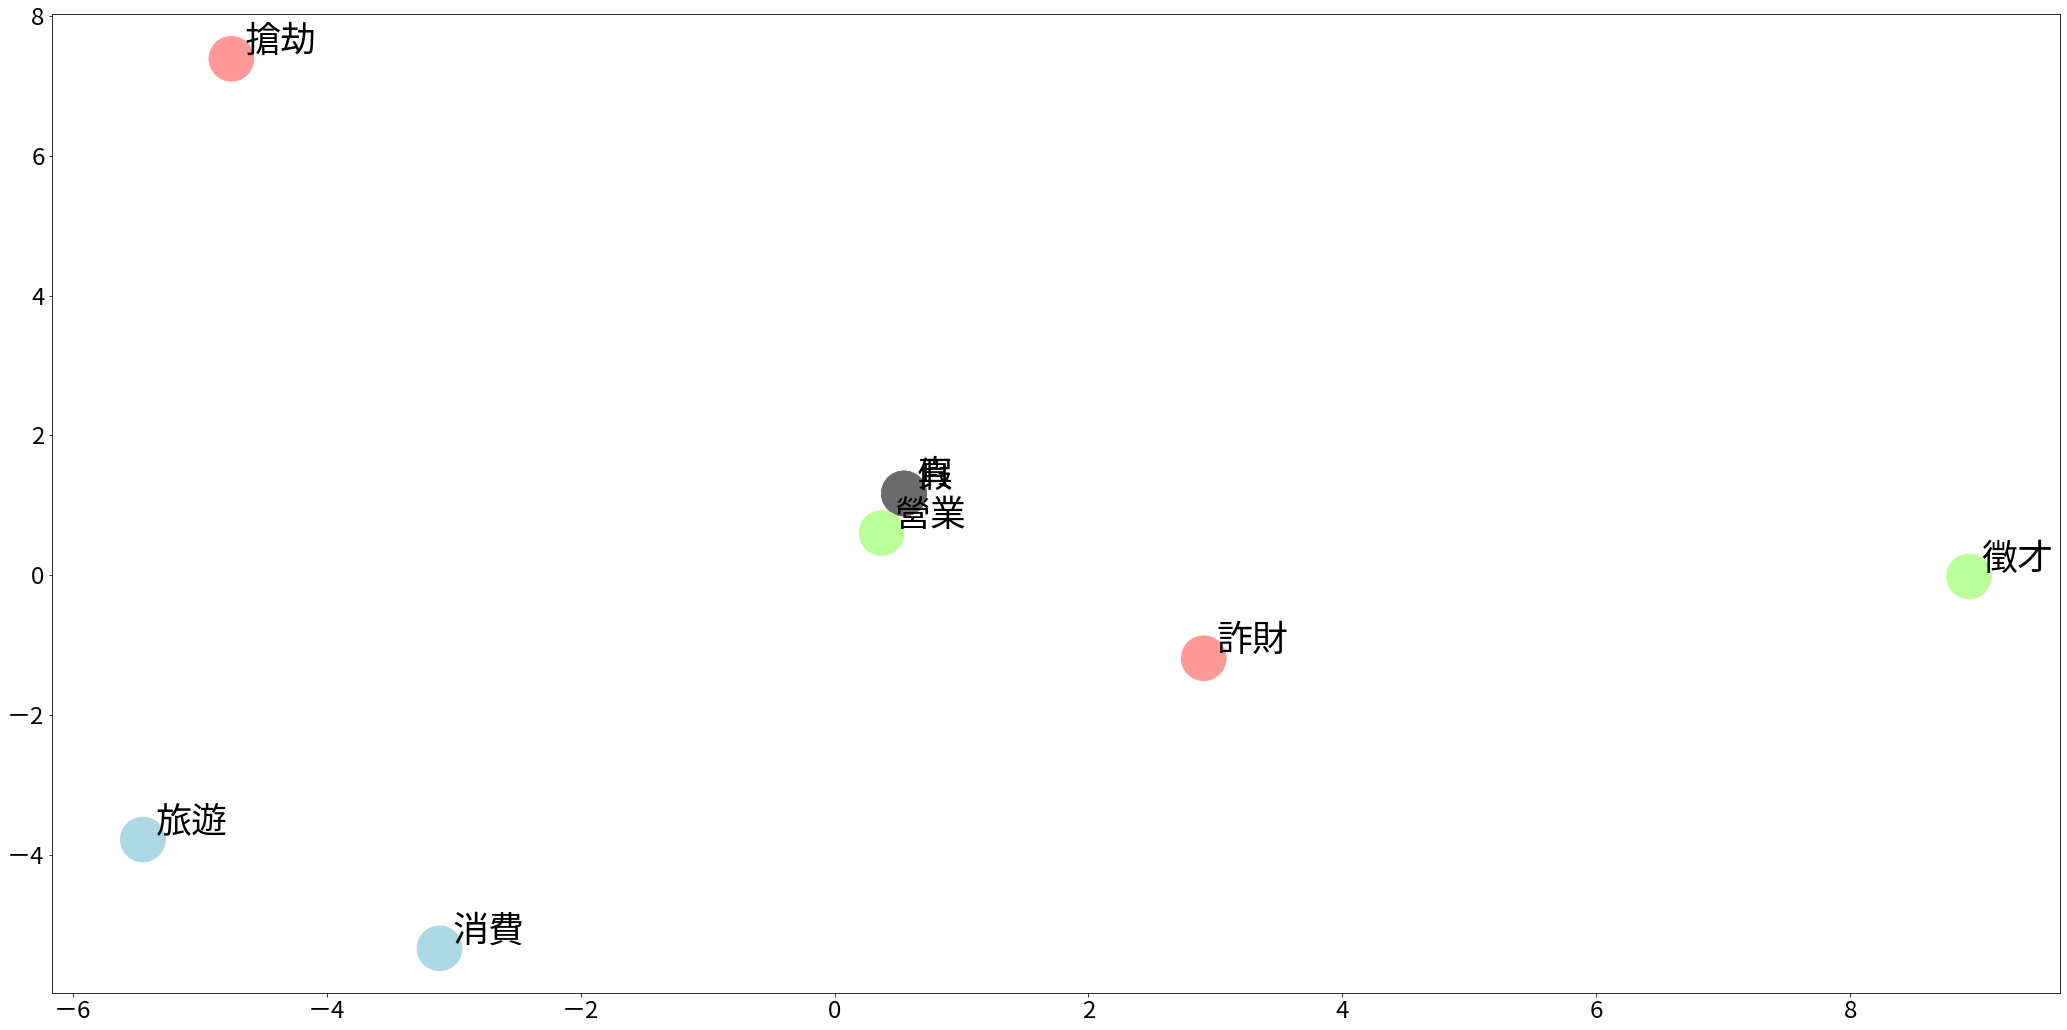

In [55]:
# select a few representative words

vec_ls_jia = []
for words in wd_ls:
  vec_ls_jia.append(wv_jia[words])
vec_df_jia = pd.DataFrame(vec_ls_jia, index=wd_ls)

pca_matrix_jia = pca.fit(vec_df_jia).transform(vec_df_jia)
pca_df_jia = pd.DataFrame(pca_matrix_jia)
pca_df_jia = pca_df_jia.set_axis(["X_jia", "Y_jia"], axis=1)
pca_df_jia.index = vec_df_jia.index.to_list()

figzoom, axzoom = plt.subplots(figsize = (36,18))
axzoom.tick_params(labelsize=24)

axzoom.scatter(pca_df_jia["X_jia"], pca_df_jia["Y_jia"], c = cl_ls, s = 2000)
for i, label in enumerate(pca_df_jia.index.to_list()):
    axzoom.annotate(label, (pca_df_jia["X_jia"][i]+0.1, pca_df_jia["Y_jia"][i]+0.1), fontsize = 36)
plt.show()

# 7 *zhen X zhen Y* FastText Model

## 7.1 Clean and tokenize text

In [56]:
zhen_ls = []
for i in word_sentence_list_tgr:
    zhen_temp = []
    for text in i:
        if text == '假':
          text = '真'
        zhen_temp.append(text)
    zhen_ls.append(zhen_temp)    
print(zhen_ls[0:5])

[['另', '賦稅署', '去年', '查獲', '真', '外資', '真', '逃稅', '一', '案', '成果'], ['展開', '查緝', '逃', '漏稅', '行動', '繼', '真', '華僑', '真', '逃稅', '案', '後', '查緝'], ['行動', '已', '一', '系列', '開展', '繼', '真', '華僑', '真', '逃稅', '案', '之後', '查緝'], ['鑑於', '近年', '來', '屢次', '發生', '真', '進口', '真', '結匯', '或', '真', '進口'], ['起', '智慧型', '犯罪', '集團', '以', '真', '進口', '真', '結匯', '或', '真', '進口']]


In [57]:
print(word_sentence_list_tgr[0:5])
print(oov_ls[0:5])
print(jia_ls[0:5])
print(zhen_ls[0:5])

[['另', '賦稅署', '去年', '查獲', '假', '外資', '真', '逃稅', '一', '案', '成果'], ['展開', '查緝', '逃', '漏稅', '行動', '繼', '假', '華僑', '真', '逃稅', '案', '後', '查緝'], ['行動', '已', '一', '系列', '開展', '繼', '假', '華僑', '真', '逃稅', '案', '之後', '查緝'], ['鑑於', '近年', '來', '屢次', '發生', '假', '進口', '真', '結匯', '或', '真', '進口'], ['起', '智慧型', '犯罪', '集團', '以', '假', '進口', '真', '結匯', '或', '真', '進口']]
[['另', '賦稅署', '去年', '查獲', 'OOV', '外資', 'OOV', '逃稅', '一', '案', '成果'], ['展開', '查緝', '逃', '漏稅', '行動', '繼', 'OOV', '華僑', 'OOV', '逃稅', '案', '後', '查緝'], ['行動', '已', '一', '系列', '開展', '繼', 'OOV', '華僑', 'OOV', '逃稅', '案', '之後', '查緝'], ['鑑於', '近年', '來', '屢次', '發生', 'OOV', '進口', 'OOV', '結匯', '或', 'OOV', '進口'], ['起', '智慧型', '犯罪', '集團', '以', 'OOV', '進口', 'OOV', '結匯', '或', 'OOV', '進口']]
[['另', '賦稅署', '去年', '查獲', '假', '外資', '假', '逃稅', '一', '案', '成果'], ['展開', '查緝', '逃', '漏稅', '行動', '繼', '假', '華僑', '假', '逃稅', '案', '後', '查緝'], ['行動', '已', '一', '系列', '開展', '繼', '假', '華僑', '假', '逃稅', '案', '之後', '查緝'], ['鑑於', '近年', '來', '屢次', '發生', '假', '進口', '假', '結匯', '或', '假',

## 7.2 FastText model

In [58]:
## train model
!pip install --upgrade gensim
from gensim.models import FastText

model = FastText(vector_size = 300, min_count = 1)  # instantiate
model.build_vocab(zhen_ls)
model.train(zhen_ls, total_examples = len(zhen_ls), epochs = 100)  # train

wv_zhen = model.wv

print(wv_zhen)

print(len(wv_zhen["依親"]))
print('依親' in wv_zhen.key_to_index)

300
True


## 7.3 Construction matrix


In [59]:
vec_ls_zhen = []

for i in data.iterrows():
    vec_X = wv_zhen[i[1]['X'].replace(' ', '')]
    vec_Y = wv_zhen[i[1]['Y'].replace(' ', '')]

    ls = [vec_X, vec_Y]
    vec_ls_zhen.append(ls)

In [60]:
vec_df_zhen = pd.DataFrame(vec_ls_zhen)
vec_df_zhen = vec_df_zhen.rename(columns = {0:'X_vec', 1:'Y_vec'})

In [61]:
X_vec_df_zhen = pd.DataFrame(vec_df_zhen['X_vec'].to_list())
X = pd.DataFrame(data['X'])
X_vec_df_zhen = X_vec_df_zhen.join(X).set_index('X')

Y_vec_df_zhen = pd.DataFrame(vec_df_zhen['Y_vec'].to_list())
Y = pd.DataFrame(data['Y'])
Y_vec_df_zhen = Y_vec_df_zhen.join(Y).set_index('Y')

## 7.4 PCA to lower dimensions

In [62]:
# PCA to two dimensions
from sklearn.decomposition import PCA

pca_matrix_X_zhen = pca.fit(X_vec_df_zhen).transform(X_vec_df_zhen)
pca_df_X_zhen = pd.DataFrame(pca_matrix_X_zhen)
pca_df_X_zhen = pca_df_X_zhen.set_axis(["X", "Y"], axis=1)
pca_df_X_zhen.index = X_vec_df_zhen.index.to_list()

pca_matrix_Y_zhen = pca.fit(Y_vec_df_zhen).transform(Y_vec_df_zhen)
pca_df_Y_zhen = pd.DataFrame(pca_matrix_Y_zhen)
pca_df_Y_zhen = pca_df_Y_zhen.set_axis(["X", "Y"], axis=1)
pca_df_Y_zhen.index = Y_vec_df_zhen.index.to_list()

## 7.5 Plot

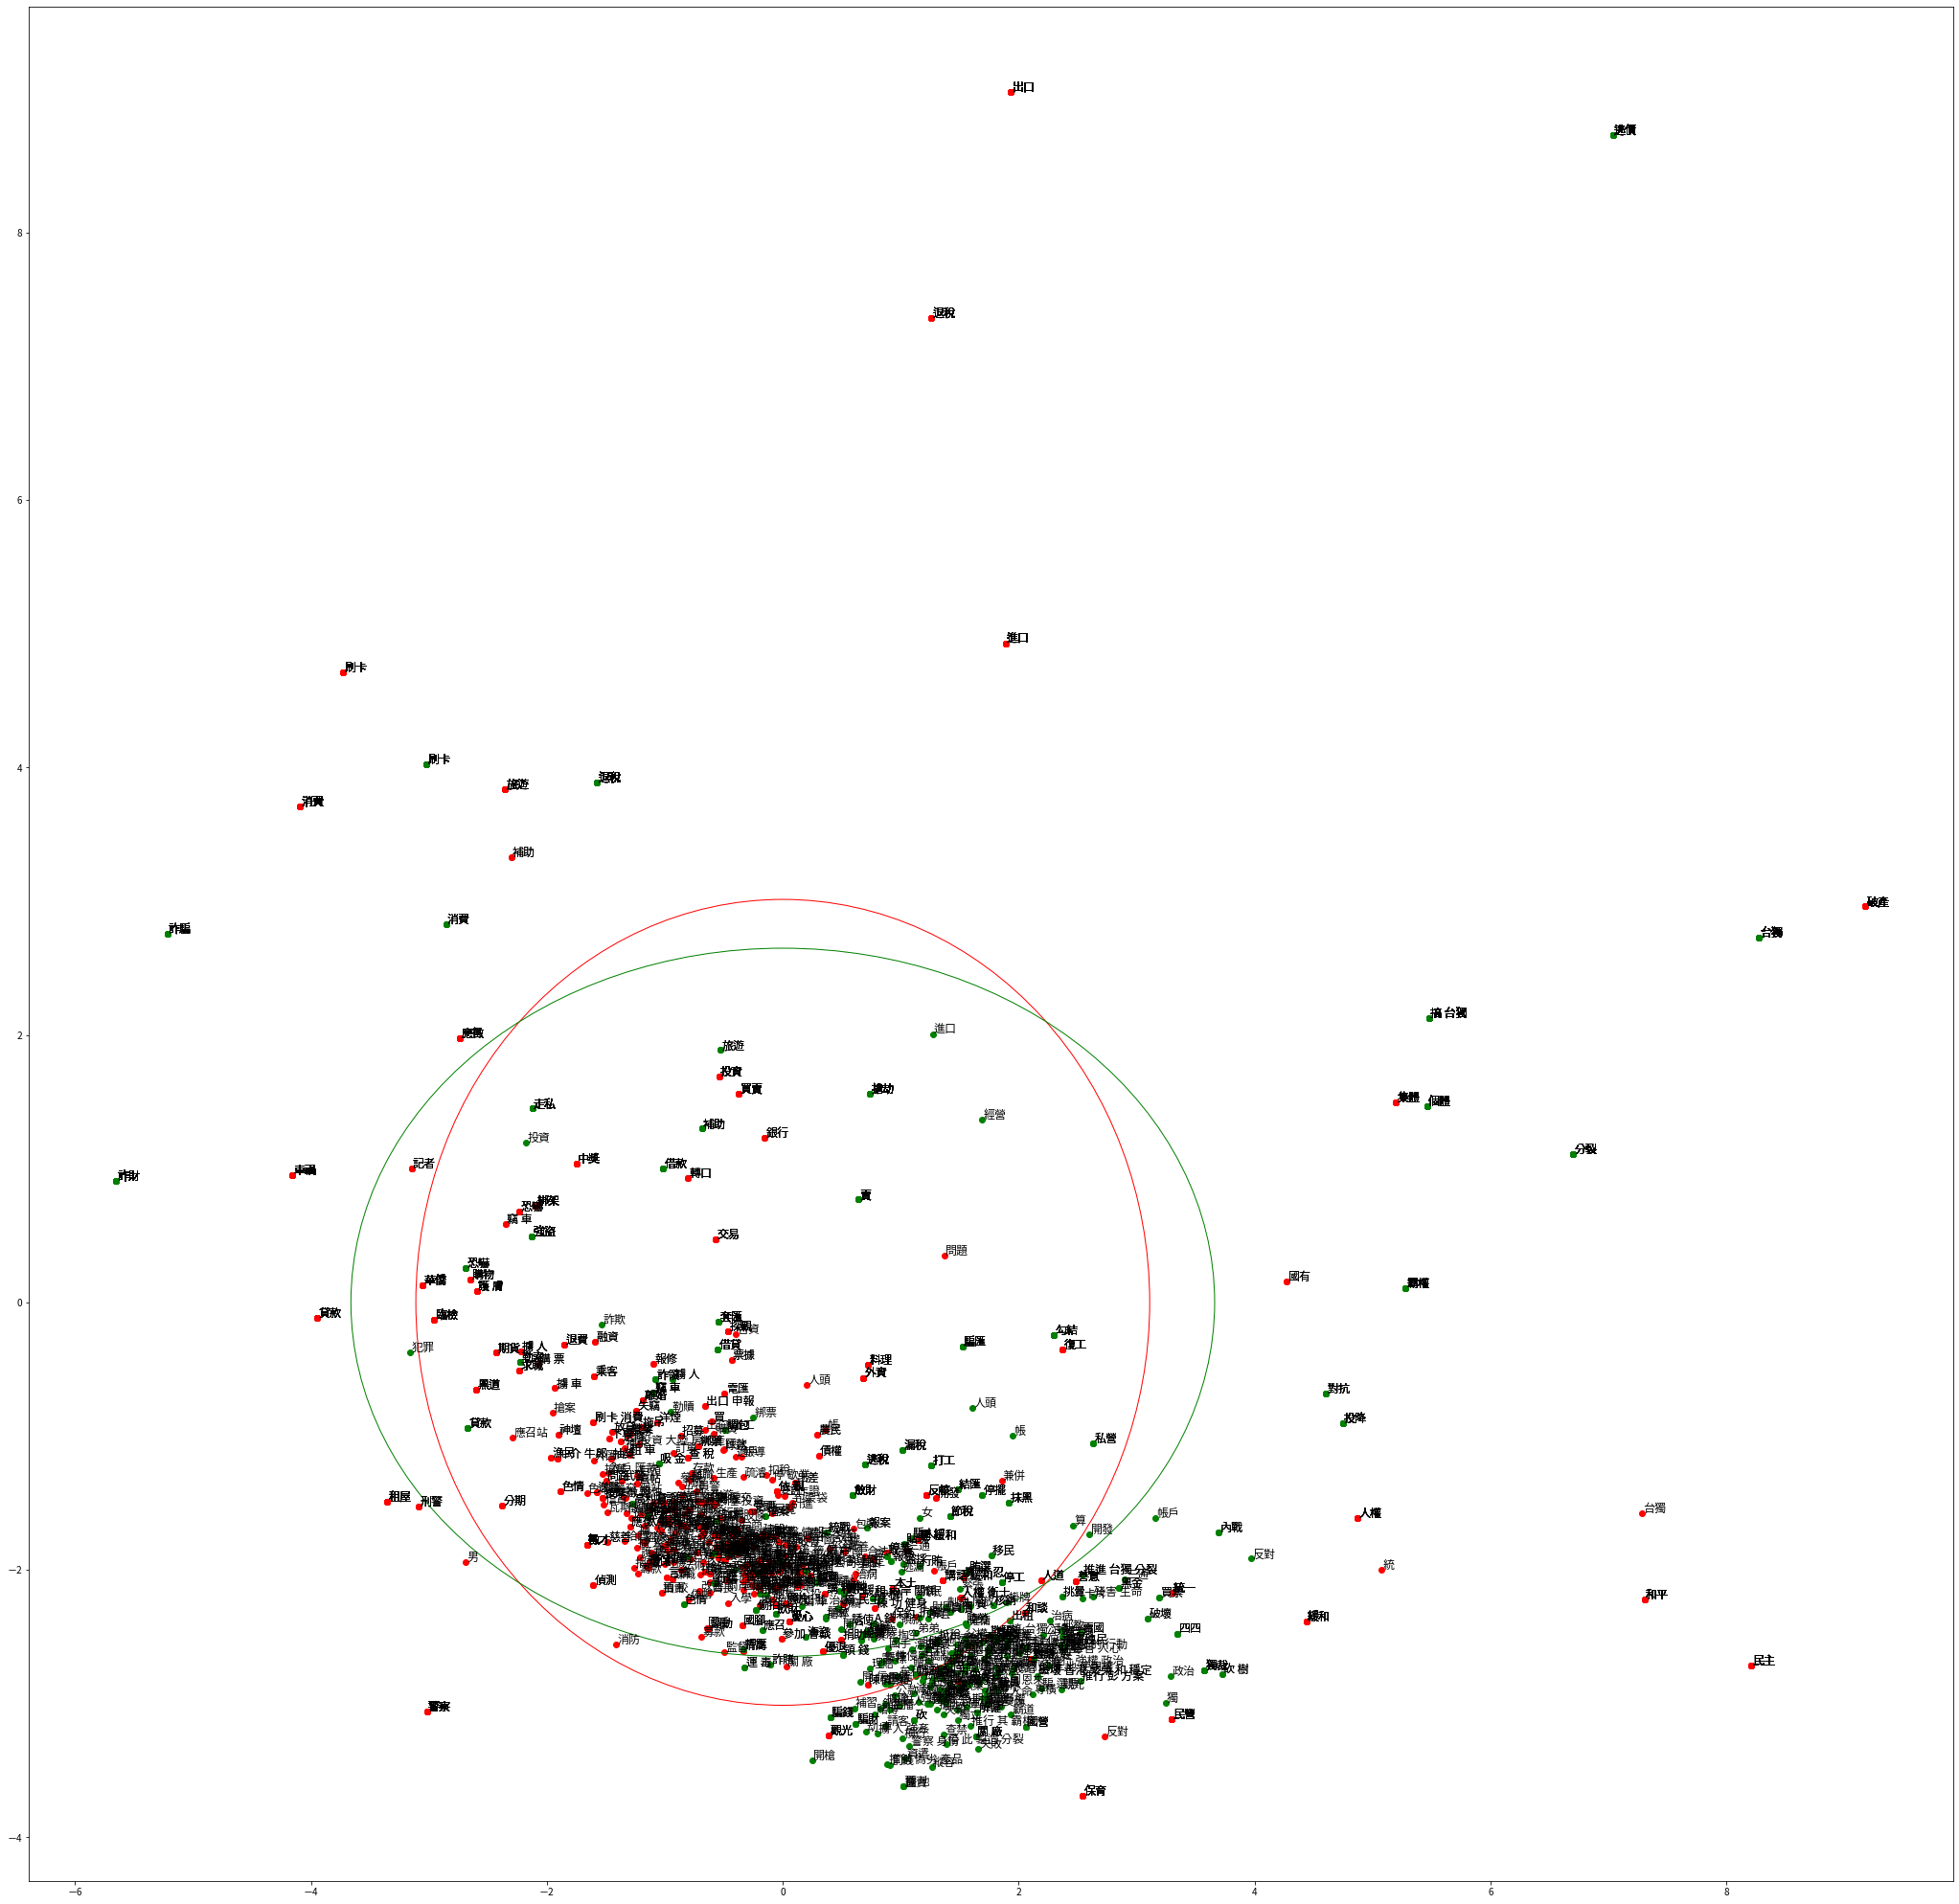

<Figure size 432x288 with 0 Axes>

In [63]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import numpy as np

figzoom, axzoom = plt.subplots(figsize = (36,36))

axzoom.scatter(pca_df_X_zhen["X"], pca_df_X_zhen["Y"], c = "red")
confidence_ellipse(pca_df_X_zhen["X"], pca_df_X_zhen["Y"], axzoom, n_std = 1, label = r'$1\sigma$', edgecolor = 'red')
for i, label in enumerate(pca_df_X_zhen.index.to_list()):
    axzoom.annotate(label, (pca_df_X_zhen["X"][i]+0.01, pca_df_X_zhen["Y"][i]+0.01), fontsize = 12)

axzoom.scatter(pca_df_Y_zhen["X"], pca_df_Y_zhen["Y"], c = "green")
confidence_ellipse(pca_df_Y_zhen["X"], pca_df_Y_zhen["Y"], axzoom, n_std = 1, label = r'$1\sigma$', edgecolor = 'green')
for i, label in enumerate(pca_df_Y_zhen.index.to_list()):
    axzoom.annotate(label, (pca_df_Y_zhen["X"][i]+0.01, pca_df_Y_zhen["Y"][i]+0.01), fontsize = 12)

plt.show()

plt.savefig("fig_zhen.jpg")

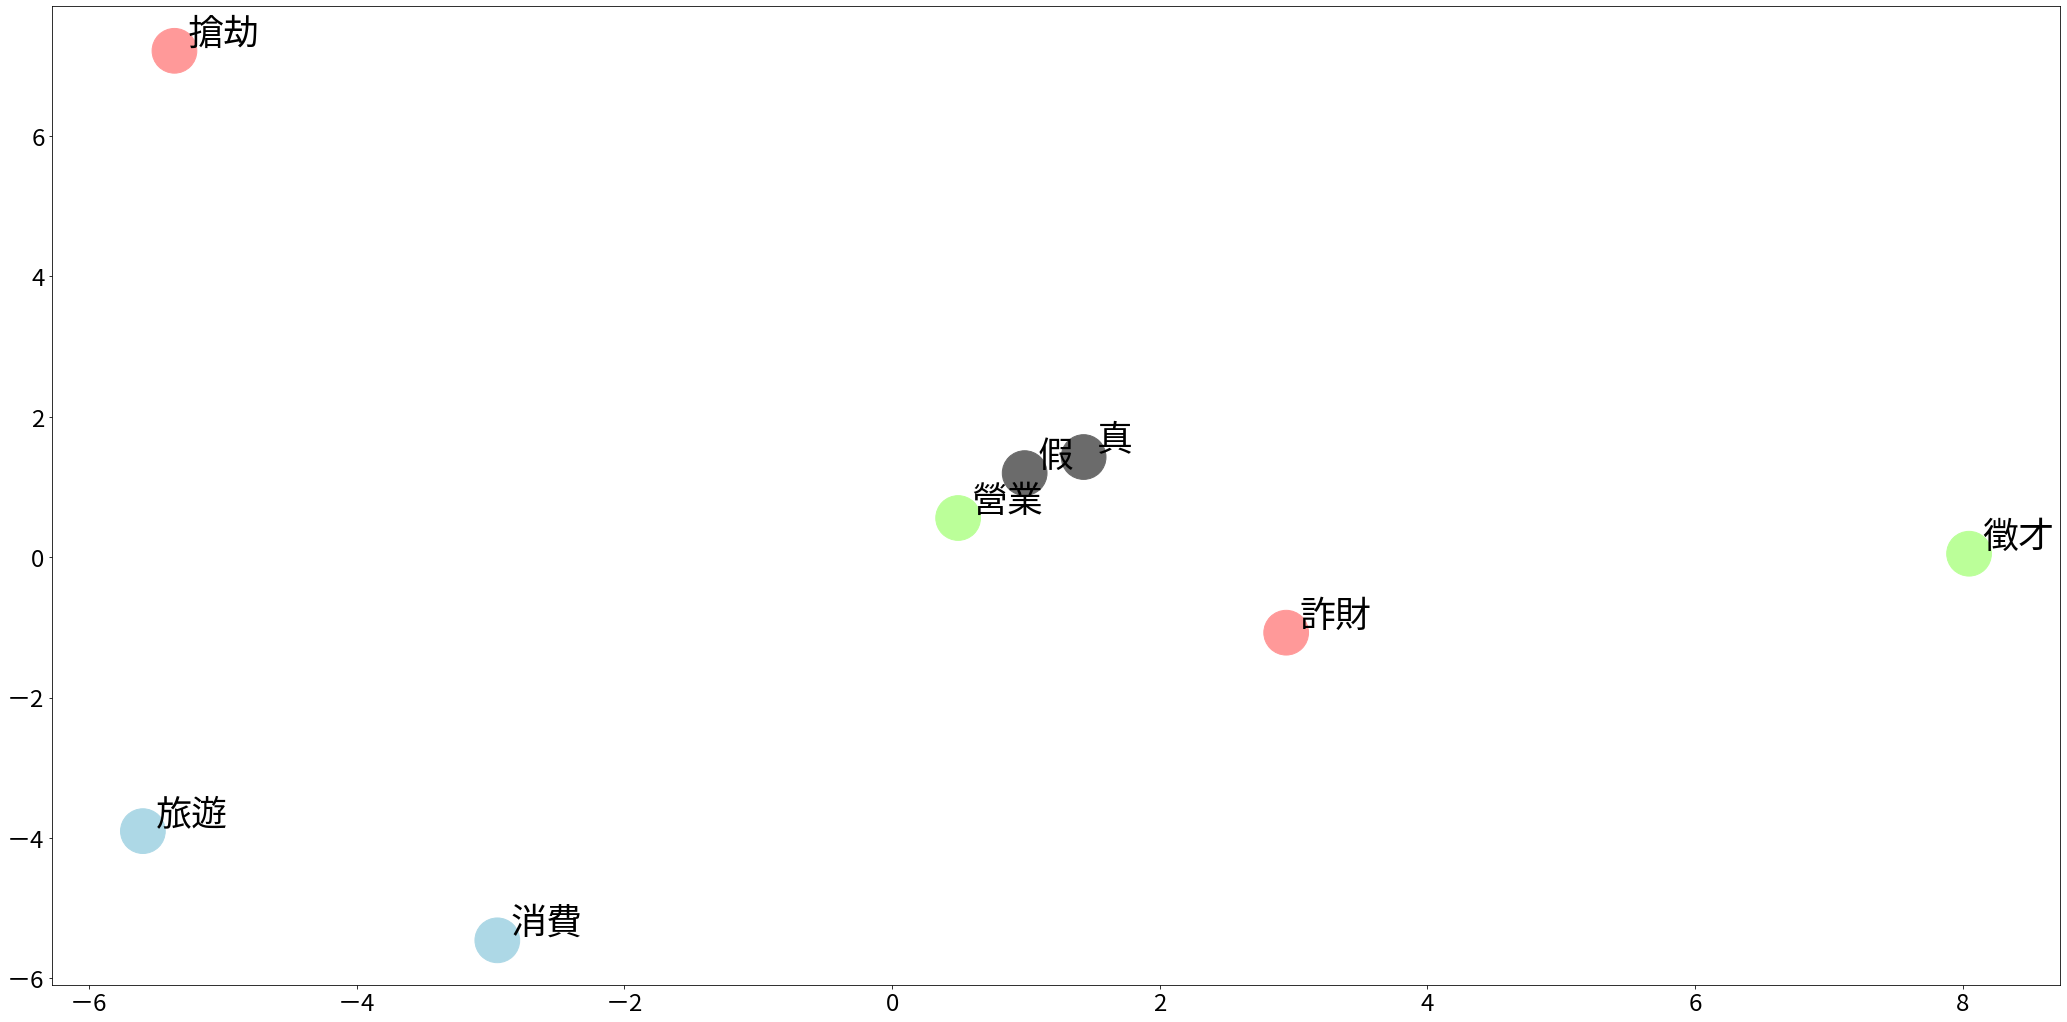

In [64]:
# select a few representative words
vec_ls_zhen = []
for words in wd_ls:
  vec_ls_zhen.append(wv_zhen[words])
vec_df_zhen = pd.DataFrame(vec_ls_zhen, index=wd_ls)

pca_matrix_zhen = pca.fit(vec_df_zhen).transform(vec_df_zhen)
pca_df_zhen = pd.DataFrame(pca_matrix_zhen)
pca_df_zhen = pca_df_zhen.set_axis(["X_zhen", "Y_zhen"], axis=1)
pca_df_zhen.index = vec_df_zhen.index.to_list()

figzoom, axzoom = plt.subplots(figsize = (36,18))
axzoom.tick_params(labelsize=24)

axzoom.scatter(pca_df_zhen["X_zhen"], pca_df_zhen["Y_zhen"], c = cl_ls, s = 2000)
for i, label in enumerate(pca_df_zhen.index.to_list()):
    axzoom.annotate(label, (pca_df_zhen["X_zhen"][i]+0.1, pca_df_zhen["Y_zhen"][i]+0.1), fontsize = 36)
plt.show()

# 8 *X Y* FastText Model (*jia* and *zhen* removed)

## 8.1 Clean and tokenize text

In [65]:
rm_ls = []
for i in word_sentence_list_tgr:
    rm_temp = []
    for text in i:
        if text == '假' or text == '真':
            continue
        else:
          rm_temp.append(text)
    rm_ls.append(rm_temp)    
print(rm_ls[0:5])

[['另', '賦稅署', '去年', '查獲', '外資', '逃稅', '一', '案', '成果'], ['展開', '查緝', '逃', '漏稅', '行動', '繼', '華僑', '逃稅', '案', '後', '查緝'], ['行動', '已', '一', '系列', '開展', '繼', '華僑', '逃稅', '案', '之後', '查緝'], ['鑑於', '近年', '來', '屢次', '發生', '進口', '結匯', '或', '進口'], ['起', '智慧型', '犯罪', '集團', '以', '進口', '結匯', '或', '進口']]


In [66]:
print(word_sentence_list_tgr[0:5])
print(oov_ls[0:5])
print(jia_ls[0:5])
print(zhen_ls[0:5])
print(rm_ls[0:5])

[['另', '賦稅署', '去年', '查獲', '假', '外資', '真', '逃稅', '一', '案', '成果'], ['展開', '查緝', '逃', '漏稅', '行動', '繼', '假', '華僑', '真', '逃稅', '案', '後', '查緝'], ['行動', '已', '一', '系列', '開展', '繼', '假', '華僑', '真', '逃稅', '案', '之後', '查緝'], ['鑑於', '近年', '來', '屢次', '發生', '假', '進口', '真', '結匯', '或', '真', '進口'], ['起', '智慧型', '犯罪', '集團', '以', '假', '進口', '真', '結匯', '或', '真', '進口']]
[['另', '賦稅署', '去年', '查獲', 'OOV', '外資', 'OOV', '逃稅', '一', '案', '成果'], ['展開', '查緝', '逃', '漏稅', '行動', '繼', 'OOV', '華僑', 'OOV', '逃稅', '案', '後', '查緝'], ['行動', '已', '一', '系列', '開展', '繼', 'OOV', '華僑', 'OOV', '逃稅', '案', '之後', '查緝'], ['鑑於', '近年', '來', '屢次', '發生', 'OOV', '進口', 'OOV', '結匯', '或', 'OOV', '進口'], ['起', '智慧型', '犯罪', '集團', '以', 'OOV', '進口', 'OOV', '結匯', '或', 'OOV', '進口']]
[['另', '賦稅署', '去年', '查獲', '假', '外資', '假', '逃稅', '一', '案', '成果'], ['展開', '查緝', '逃', '漏稅', '行動', '繼', '假', '華僑', '假', '逃稅', '案', '後', '查緝'], ['行動', '已', '一', '系列', '開展', '繼', '假', '華僑', '假', '逃稅', '案', '之後', '查緝'], ['鑑於', '近年', '來', '屢次', '發生', '假', '進口', '假', '結匯', '或', '假',

## 8.2 FastText model

In [67]:
## train model
!pip install --upgrade gensim
from gensim.models import FastText

model = FastText(vector_size = 300, min_count = 1)  # instantiate
model.build_vocab(rm_ls)
model.train(rm_ls, total_examples = len(rm_ls), epochs = 100)  # train

wv_rm = model.wv

print(wv_rm)

print(len(wv_rm["依親"]))
print('依親' in wv_rm.key_to_index)

300
True


## 8.3 Construction matrix


In [68]:
vec_ls_rm = []

for i in data.iterrows():
    vec_X = wv_rm[i[1]['X'].replace(' ', '')]
    vec_Y = wv_rm[i[1]['Y'].replace(' ', '')]

    ls = [vec_X, vec_Y]
    vec_ls_rm.append(ls)

In [69]:
vec_df_rm = pd.DataFrame(vec_ls_rm)
vec_df_rm = vec_df_rm.rename(columns = {0:'X_vec', 1:'Y_vec'})

In [70]:
X_vec_df_rm = pd.DataFrame(vec_df_rm['X_vec'].to_list())
X = pd.DataFrame(data['X'])
X_vec_df_rm = X_vec_df_rm.join(X).set_index('X')
print(X_vec_df_rm.head(5))

Y_vec_df_rm = pd.DataFrame(vec_df_rm['Y_vec'].to_list())
Y = pd.DataFrame(data['Y'])
Y_vec_df_rm = Y_vec_df_rm.join(Y).set_index('Y')
print(Y_vec_df_rm.head(5))

         0         1         2    ...       297       298       299
X                                 ...                              
外資 -0.192829  0.147916 -0.364901  ... -0.115624 -0.472652 -0.384544
華僑  0.144639  0.215127  0.020347  ...  0.503701 -0.375259  0.091609
華僑  0.144639  0.215127  0.020347  ...  0.503701 -0.375259  0.091609
進口  0.027308 -0.431617 -0.102084  ... -0.342681 -0.161695 -0.455557
進口  0.027308 -0.431617 -0.102084  ... -0.342681 -0.161695 -0.455557

[5 rows x 300 columns]
         0         1         2    ...       297       298       299
Y                                 ...                              
逃稅 -0.216420 -0.007818 -0.187635  ... -0.128056 -0.673421 -0.091142
逃稅 -0.216420 -0.007818 -0.187635  ... -0.128056 -0.673421 -0.091142
逃稅 -0.216420 -0.007818 -0.187635  ... -0.128056 -0.673421 -0.091142
結匯  0.094724 -0.134066  0.083465  ... -0.200275  0.040148 -0.185775
結匯  0.094724 -0.134066  0.083465  ... -0.200275  0.040148 -0.185775

[5 rows x 300 columns]


## 8.4 PCA to lower dimensions

In [71]:
# PCA to two dimensions
from sklearn.decomposition import PCA

pca_matrix_X_rm = pca.fit(X_vec_df_rm).transform(X_vec_df_rm)
pca_df_X_rm = pd.DataFrame(pca_matrix_X_rm)
pca_df_X_rm = pca_df_X_rm.set_axis(["X", "Y"], axis=1)
pca_df_X_rm.index = X_vec_df_rm.index.to_list()

pca_matrix_Y_rm = pca.fit(Y_vec_df_rm).transform(Y_vec_df_rm)
pca_df_Y_rm = pd.DataFrame(pca_matrix_Y_rm)
pca_df_Y_rm = pca_df_Y_rm.set_axis(["X", "Y"], axis=1)
pca_df_Y_rm.index = Y_vec_df_rm.index.to_list()

## 8.5 Plot

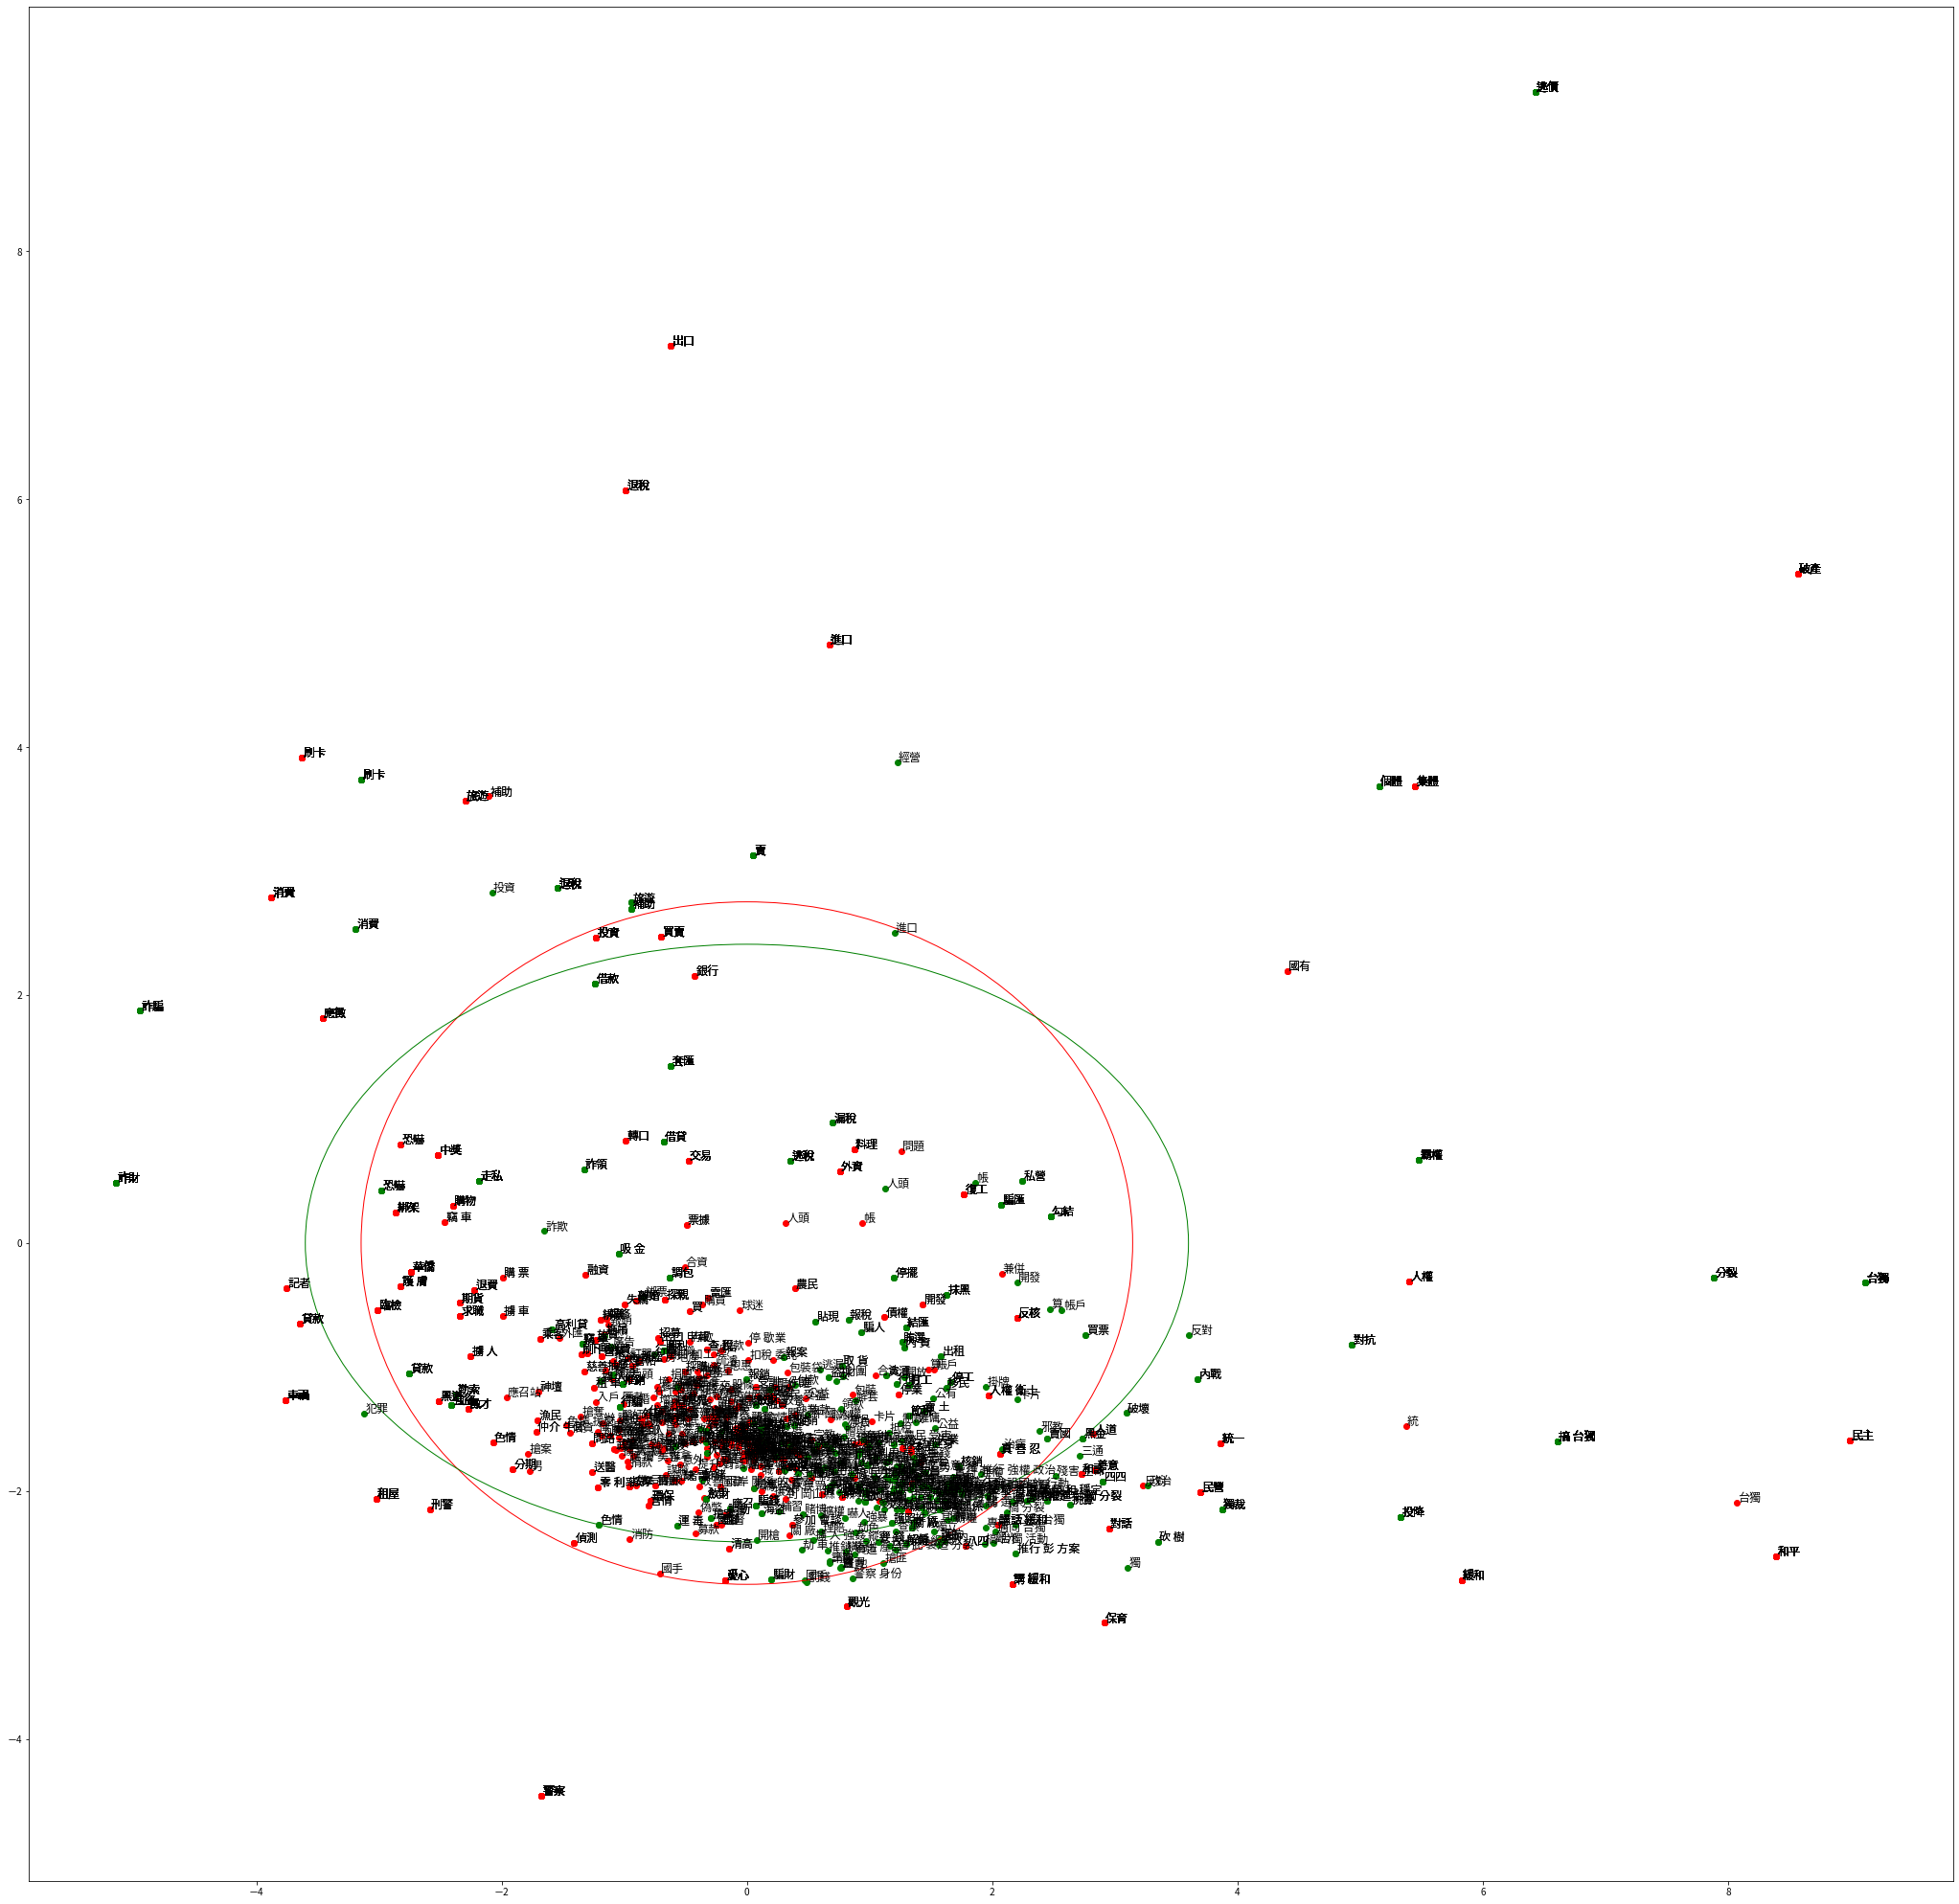

<Figure size 432x288 with 0 Axes>

In [72]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import numpy as np

figzoom, axzoom = plt.subplots(figsize = (36,36))

axzoom.scatter(pca_df_X_rm["X"], pca_df_X_rm["Y"], c = "red")
confidence_ellipse(pca_df_X_rm["X"], pca_df_X_rm["Y"], axzoom, n_std = 1, label = r'$1\sigma$', edgecolor = 'red')
for i, label in enumerate(pca_df_X_rm.index.to_list()):
    axzoom.annotate(label, (pca_df_X_rm["X"][i]+0.01, pca_df_X_rm["Y"][i]+0.01), fontsize = 12)

axzoom.scatter(pca_df_Y_rm["X"], pca_df_Y_rm["Y"], c = "green")
confidence_ellipse(pca_df_Y_rm["X"], pca_df_Y_rm["Y"], axzoom, n_std = 1, label = r'$1\sigma$', edgecolor = 'green')
for i, label in enumerate(pca_df_Y_rm.index.to_list()):
    axzoom.annotate(label, (pca_df_Y_rm["X"][i]+0.01, pca_df_Y_rm["Y"][i]+0.01), fontsize = 12)

plt.show()

plt.savefig("fig_rm.jpg")

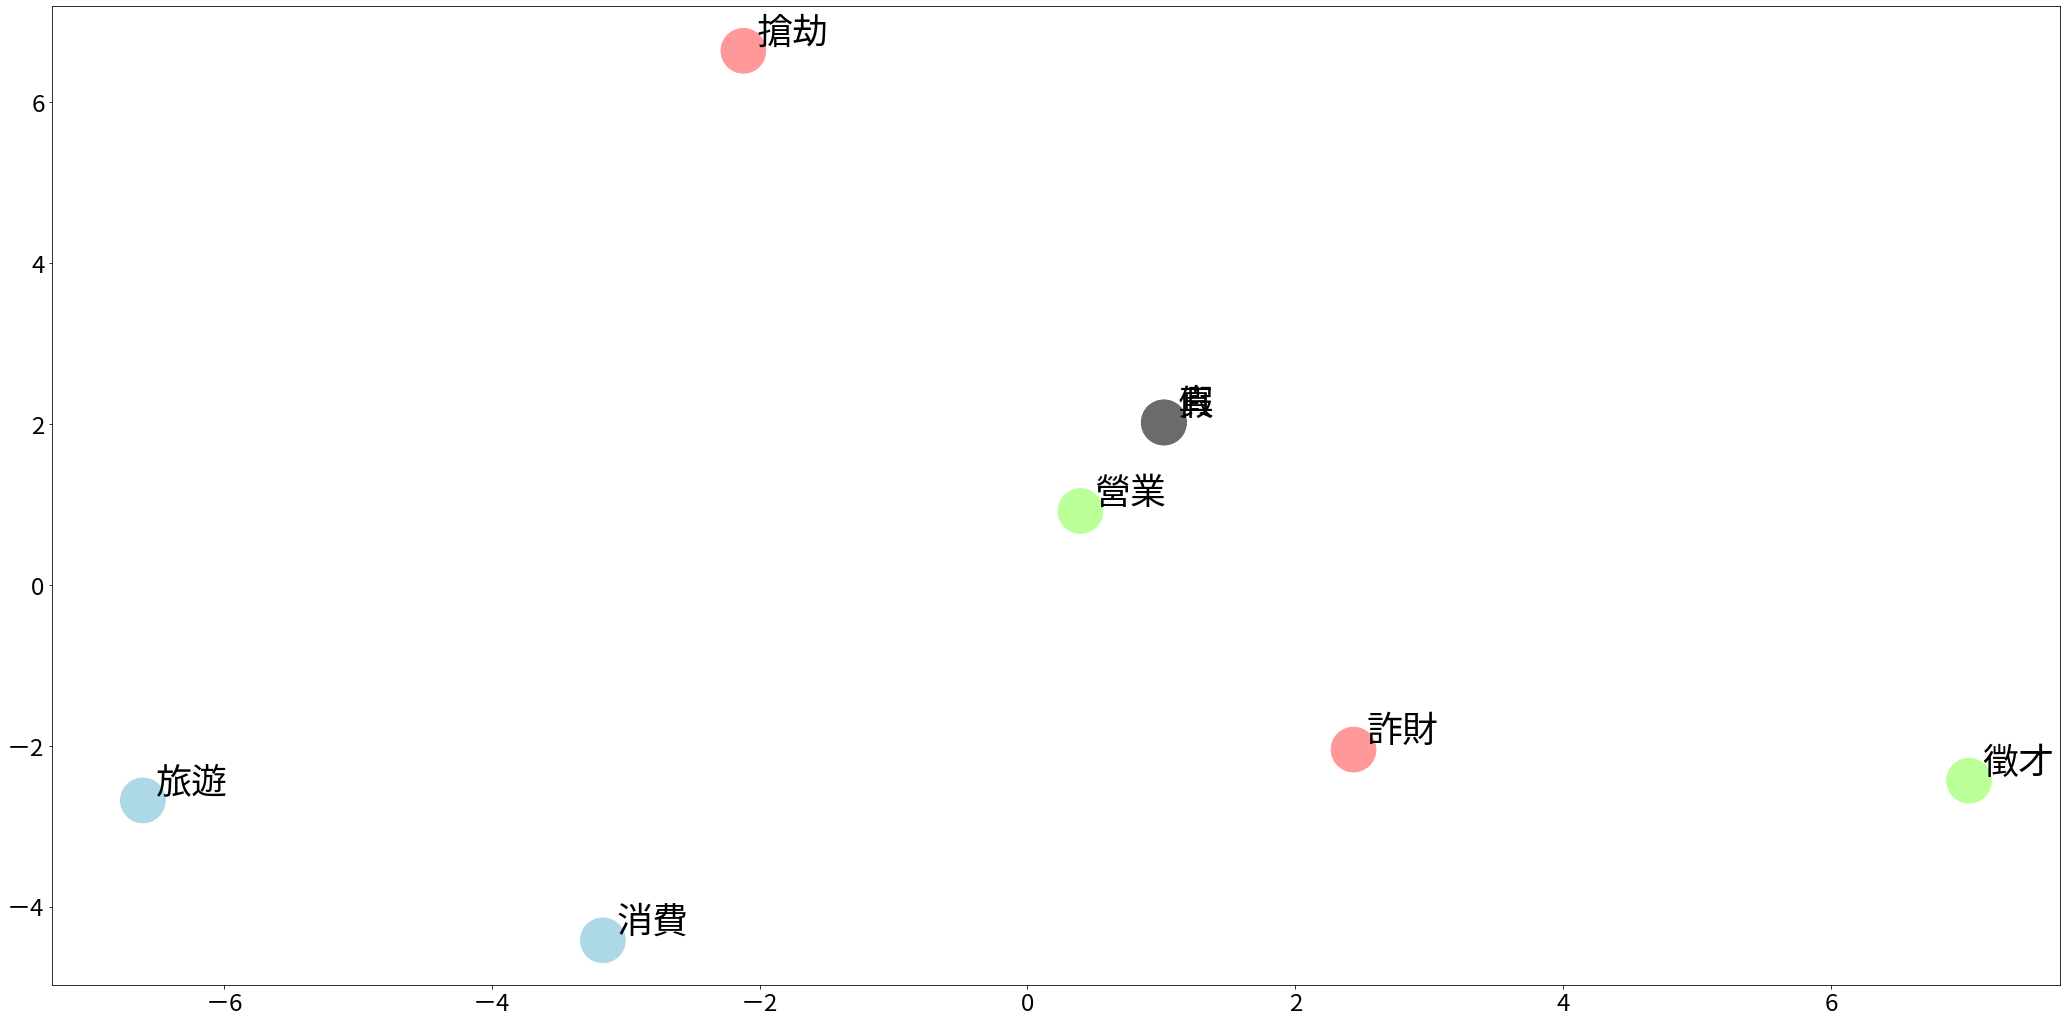

In [73]:
# select a few representative words
vec_ls_rm = []
for words in wd_ls:
  vec_ls_rm.append(wv_rm[words])
vec_df_rm = pd.DataFrame(vec_ls_rm, index=wd_ls)

pca_matrix_rm = pca.fit(vec_df_rm).transform(vec_df_rm)
pca_df_rm = pd.DataFrame(pca_matrix_rm)
pca_df_rm = pca_df_rm.set_axis(["X_rm", "Y_rm"], axis=1)
pca_df_rm.index = vec_df_rm.index.to_list()

figzoom, axzoom = plt.subplots(figsize = (36,18))
axzoom.tick_params(labelsize=24)

axzoom.scatter(pca_df_rm["X_rm"], pca_df_rm["Y_rm"], c = cl_ls, s = 2000)
for i, label in enumerate(pca_df_rm.index.to_list()):
    axzoom.annotate(label, (pca_df_rm["X_rm"][i]+0.1, pca_df_rm["Y_rm"][i]+0.1), fontsize = 36)
plt.show()

# 9 Comparison Among Models

In [74]:
from functools import reduce

data_frames = [pca_df_tgr, pca_df_oov, pca_df_jia, pca_df_zhen, pca_df_rm]

pca_df_all = pd.concat(data_frames, axis=1)
pca_df_all

,X_tgr,Y_tgr,X_oov,Y_oov,X_jia,Y_jia,X_zhen,Y_zhen,X_rm,Y_rm
假,1.572741,1.690525,0.626216,1.222979,0.545765,1.169891,0.990786,1.196130,1.017552,2.016867
真,1.800981,0.714969,0.628949,1.221099,0.547993,1.167882,1.431366,1.425006,1.019676,2.016417
營業,0.527880,0.299780,0.245192,0.546385,0.370955,0.602519,0.493746,0.556638,0.395501,0.915809
徵才,7.386811,-0.217204,8.779516,0.376194,8.935837,-0.018392,8.046137,0.048215,7.032023,-2.435844
搶劫,-4.998231,7.366245,-5.503993,7.277238,-4.750256,7.389583,-5.360863,7.209939,-2.121789,6.635727
詐財,2.732511,-0.988315,2.952968,-0.645678,2.908063,-1.188333,2.944443,-1.076351,2.435070,-2.048746
消費,-2.708927,-5.259394,-2.509890,-5.607233,-3.110696,-5.339957,-2.948903,-5.457231,-3.171411,-4.419448
旅遊,-6.313766,-3.606605,-5.218959,-4.390984,-5.447660,-3.783192,-5.596712,-3.902346,-6.606623,-2.680781


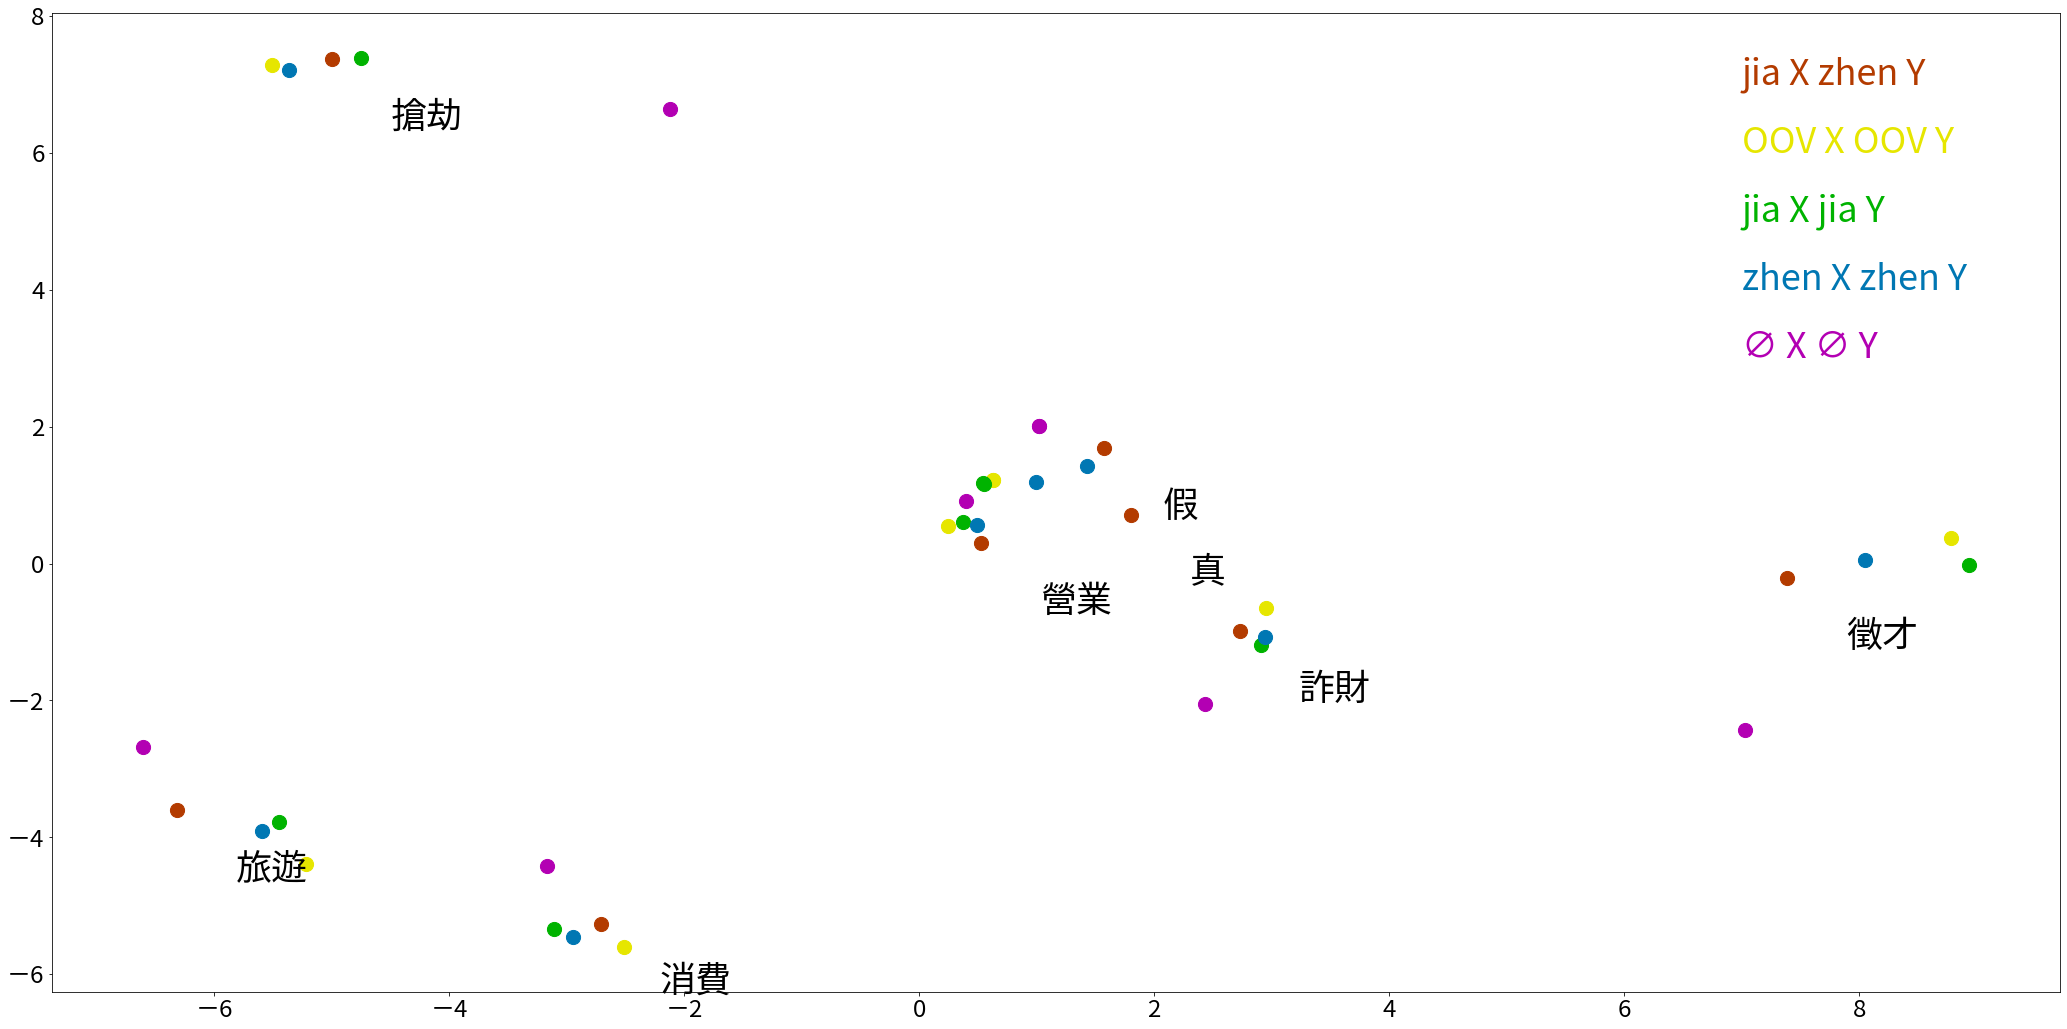

In [75]:
figzoom, axzoom = plt.subplots(figsize = (36,18))

axzoom.tick_params(labelsize=24)

axzoom.scatter(pca_df_all["X_tgr"], pca_df_all["Y_tgr"], c = '#B33B00', s = 200)
axzoom.text(7, 7, 'jia X zhen Y', size = 36, color = '#B33B00')
axzoom.scatter(pca_df_all["X_oov"], pca_df_all["Y_oov"], c = '#E6E600', s = 200)
axzoom.text(7, 6, 'OOV X OOV Y', size = 36, color = '#E6E600')
axzoom.scatter(pca_df_all["X_jia"], pca_df_all["Y_jia"], c = '#00B300', s = 200)
axzoom.text(7, 5, 'jia X jia Y', size = 36, color = '#00B300')
axzoom.scatter(pca_df_all["X_zhen"], pca_df_all["Y_zhen"], c = '#0077B3', s = 200)
axzoom.text(7, 4, 'zhen X zhen Y', size = 36, color = '#0077B3')
axzoom.scatter(pca_df_all["X_rm"], pca_df_all["Y_rm"], c = '#B300B3', s = 200)
axzoom.text(7, 3, '∅ X ∅ Y', size = 36, color = '#B300B3')

for i, label in enumerate(pca_df_all.index.to_list()):
    axzoom.annotate(label, (pca_df_all["X_tgr"][i]+0.5, pca_df_all["Y_tgr"][i]-1.0), fontsize = 36)

plt.show()